# Transformer Mapping between GAT Embeddings of RNA and ADT

This notebook learns a mapping between GAT embeddings from RNA data and GAT embeddings from ADT data using a Transformer Encoder architecture.

In [1]:
# Comprehensive CUDA/PyTorch diagnostic
import torch
import sys
import os
import subprocess

print("=== PyTorch and CUDA Diagnostic ===")
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch CUDA compiled version: {torch.version.cuda}")

# Check if CUDA is available
print(f"\nCUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name()}")
else:
    print("\nCUDA not available. Possible reasons:")
    print("1. PyTorch was installed without CUDA support")
    print("2. CUDA drivers not properly installed")
    print("3. Environment variables not set correctly")

# Check environment variables
print(f"\n=== Environment Variables ===")
cuda_vars = ['CUDA_VISIBLE_DEVICES', 'CUDA_HOME', 'LD_LIBRARY_PATH', 'PATH']
for var in cuda_vars:
    value = os.environ.get(var, 'Not set')
    print(f"{var}: {value}")

# Check if nvidia-smi works
print(f"\n=== NVIDIA System Management Interface ===")
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=10)
    if result.returncode == 0:
        print("nvidia-smi output:")
        print(result.stdout)
    else:
        print(f"nvidia-smi failed: {result.stderr}")
except FileNotFoundError:
    print("nvidia-smi not found - NVIDIA drivers may not be installed")
except subprocess.TimeoutExpired:
    print("nvidia-smi timed out")
except Exception as e:
    print(f"Error running nvidia-smi: {e}")

# Check PyTorch installation details
print(f"\n=== PyTorch Installation Details ===")
print(f"PyTorch built with CUDA: {torch.cuda.is_available()}")
if hasattr(torch.backends, 'cudnn'):
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"cuDNN enabled: {torch.backends.cudnn.enabled}")

# Check if we can import torch.cuda
try:
    import torch.cuda
    print("torch.cuda module imported successfully")
except ImportError as e:
    print(f"Failed to import torch.cuda: {e}")

print("=" * 50)

=== PyTorch and CUDA Diagnostic ===
Python version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:12:24) [GCC 11.2.0]
PyTorch version: 2.7.1+cu126
PyTorch CUDA compiled version: 12.6

CUDA available: False

CUDA not available. Possible reasons:
1. PyTorch was installed without CUDA support
2. CUDA drivers not properly installed
3. Environment variables not set correctly

=== Environment Variables ===
CUDA_VISIBLE_DEVICES: Not set
CUDA_HOME: Not set
LD_LIBRARY_PATH: /shared/EL9/explorer/anaconda3/2024.06/lib:/shared/EL9/explorer/nodejs/v22.11.0/lib:/lib:
PATH: /shared/EL9/explorer/anaconda3/2024.06/sbin:/shared/EL9/explorer/nodejs/v22.11.0/bin:/shared/EL9/explorer/explorer/bin:/shared/EL9/explorer/anaconda3/2024.06/bin:/shared/EL9/explorer/anaconda3/2024.06/condabin:/work/vanaja_lab/satya/bin:/work/vanaja_lab/satya/envs/scipennenv/bin:/usr/share/Modules/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/home/nandivada.s/.local/bin:/home/nandivada.s/bin

=== NVIDIA Sys

In [2]:
# Memory optimization and system check
import torch
import os

# Set memory management environment variables

os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # or whatever GPU ID you want to use

# Check system resources
print("=== System Resources ===")
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    gpu_props = torch.cuda.get_device_properties(device)
    total_memory = gpu_props.total_memory / (1024**3)  # Convert to GB
    
    print(f"GPU: {gpu_props.name}")
    print(f"Total GPU Memory: {total_memory:.1f} GB")
    print(f"GPU Compute Capability: {gpu_props.major}.{gpu_props.minor}")
    
    # Clear any cached memory
    torch.cuda.empty_cache()
    
    # Check current memory usage
    allocated = torch.cuda.memory_allocated(device) / (1024**3)
    reserved = torch.cuda.memory_reserved(device) / (1024**3)
    
    print(f"Currently allocated: {allocated:.2f} GB")
    print(f"Currently reserved: {reserved:.2f} GB")
    print(f"Available: {total_memory - reserved:.2f} GB")
    
    # Set recommendations based on available memory
    if total_memory < 8:
        print("\n⚠️  WARNING: Low GPU memory detected!")
        print("Recommendations:")
        print("- Use CPU fallback if needed")
        print("- Reduce batch sizes")
        print("- Use graph sparsification")
    elif total_memory < 16:
        print("\n💡 Moderate GPU memory - will use optimized settings")
    else:
        print("\n✅ Sufficient GPU memory available")
        
else:
    print("CUDA not available - will use CPU")
    print("Note: Training will be slower but should work with larger graphs")

print("=" * 50)

=== System Resources ===
CUDA not available - will use CPU
Note: Training will be slower but should work with larger graphs


## 1. Load and Prepare Data

In [3]:
# Load the preprocessed data
from scripts.Preprocess import prepare_train_test_anndata
data = prepare_train_test_anndata()
trainGene = data[0]  # RNA data
trainADT = data[2]   # ADT data

print(f"RNA data shape: {trainGene.shape}")
print(f"ADT data shape: {trainADT.shape}")

All sample IDs in gene data: ['AML0612' 'AML3762' 'AML3133' 'AML2910' 'AML3050' 'AML2451' 'AML056'
 'AML073' 'AML055' 'AML048' 'AML052' 'AML2123' 'AML1371' 'AML4340'
 'AML4897' 'AML051' 'AML0693' 'AML3948' 'AML3730' 'AML0160' 'AML0310'
 'AML0361' 'AML038' 'AML008' 'AML043' 'AML028' 'AML006' 'AML025' 'AML003'
 'AML012' 'AML005' 'AML0048' 'AML022' 'AML0024' 'AML009' 'AML026' 'AML001'
 'AML0114' 'Control4' 'Control2' 'Control1' 'Control3' 'Control5'
 'Control0004' 'Control0058' 'Control0082' 'Control4003' 'Control0005']
AML 80% train: ['AML0024', 'AML001', 'AML3050', 'AML4340', 'AML005', 'AML006', 'AML056', 'AML025', 'AML043', 'AML051', 'AML3948', 'AML055', 'AML0693', 'AML1371', 'AML0160', 'AML048', 'AML022', 'AML0612', 'AML028', 'AML2451', 'AML2123', 'AML3762', 'AML0114', 'AML0361', 'AML3133', 'AML012', 'AML026', 'AML2910', 'AML009', 'AML008', 'AML0048']
AML 20% test: ['AML052', 'AML038', 'AML3730', 'AML0310', 'AML073', 'AML4897', 'AML003']
Control 80% train: ['Control4003', 'Control1', 

In [17]:
GSE120221_ADT=sc.read_h5ad("/projects/vanaja_lab/satya/Datasets/GSE120221/GSE120221.h5ad")

In [16]:
GSE120221_ADT

AnnData object with n_obs × n_vars = 90653 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'unintegrated_clusters', 'seurat_clusters', 'RNA_snn_res.1'
    var: 'vf_vst_counts.GSM3396161_mean', 'vf_vst_counts.GSM3396161_variance', 'vf_vst_counts.GSM3396161_variance.expected', 'vf_vst_counts.GSM3396161_variance.standardized', 'vf_vst_counts.GSM3396161_variable', 'vf_vst_counts.GSM3396161_rank', 'vf_vst_counts.GSM3396162_mean', 'vf_vst_counts.GSM3396162_variance', 'vf_vst_counts.GSM3396162_variance.expected', 'vf_vst_counts.GSM3396162_variance.standardized', 'vf_vst_counts.GSM3396162_variable', 'vf_vst_counts.GSM3396162_rank', 'vf_vst_counts.GSM3396163_mean', 'vf_vst_counts.GSM3396163_variance', 'vf_vst_counts.GSM3396163_variance.expected', 'vf_vst_counts.GSM3396163_variance.standardized', 'vf_vst_counts.GSM3396163_variable', 'vf_vst_counts.GSM3396163_rank', 'vf_vst_counts.GSM3396164_mean', 'vf_vst_counts.GSM3396164_variance', 'vf_vst_counts.GSM3396164_variance.expec

In [13]:
import scanpy as sc
import numpy as np

# Assuming trainGene is your AnnData object
print(f"Original data shape: {GSE120221_ADT.shape}")

# Basic preprocessing still needed
sc.pp.normalize_total(GSE120221_ADT, target_sum=1e4)
sc.pp.log1p(GSE120221_ADT)

# Instead of performing PCA, we'll use the precomputed X_integrated.cca embeddings
# First, let's check if these embeddings exist
if 'X_umap' in GSE120221_ADT.obsm:
    print(f"Found integrated.cca embeddings with shape: {GSE120221_ADT.obsm['X_umap'].shape}")
    
    # Build neighborhood graph directly from the integrated.cca embeddings
    # We set use_rep='X_integrated.cca' to use these embeddings instead of PCA
    sc.pp.neighbors(
        GSE120221_ADT, 
        n_neighbors=15, 
        use_rep='X_umap'  # This is the key part - use CCA embeddings
    )
    
    # Perform Leiden clustering on the neighborhood graph
    sc.tl.leiden(GSE120221_ADT, resolution=1.0)
    
    print(f"Number of clusters using integrated.cca embeddings: {GSE120221_ADT.obs['leiden'].nunique()}")
    
    # Compute UMAP using the same integrated embeddings for visualization
    sc.tl.umap(GSE120221_ADT, min_dist=0.3)
    
    # Plot the UMAP colored by leiden clusters
    sc.pl.umap(GSE120221_ADT, color=['leiden', 'sample'], wspace=0.4)
    
   
    
else:
    print("Error: X_umap embeddings not found in the AnnData object")
    # Fallback to the original PCA-based workflow
    sc.pp.highly_variable_genes(GSE120221_ADT, n_top_genes=2000, batch_key="samples")
    GSE120221_ADT = GSE120221_ADT[:, GSE120221_ADT.var.highly_variable].copy()
    sc.pp.scale(GSE120221_ADT, max_value=10)
    sc.tl.pca(GSE120221_ADT, n_comps=50, svd_solver="arpack")
    sc.pp.neighbors(GSE120221_ADT, n_neighbors=15, n_pcs=50)
    sc.tl.leiden(GSE120221_ADT, resolution=1.0)

NameError: name 'GSE120221_ADT' is not defined

In [9]:
GSE120221_ADT = sc.read_h5ad("/projects/vanaja_lab/satya/Datasets/GSE120221/GSE120221.h5ad")

In [10]:
GSE120221_ADT

AnnData object with n_obs × n_vars = 90653 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'unintegrated_clusters', 'seurat_clusters', 'RNA_snn_res.1'
    var: 'vf_vst_counts.GSM3396161_mean', 'vf_vst_counts.GSM3396161_variance', 'vf_vst_counts.GSM3396161_variance.expected', 'vf_vst_counts.GSM3396161_variance.standardized', 'vf_vst_counts.GSM3396161_variable', 'vf_vst_counts.GSM3396161_rank', 'vf_vst_counts.GSM3396162_mean', 'vf_vst_counts.GSM3396162_variance', 'vf_vst_counts.GSM3396162_variance.expected', 'vf_vst_counts.GSM3396162_variance.standardized', 'vf_vst_counts.GSM3396162_variable', 'vf_vst_counts.GSM3396162_rank', 'vf_vst_counts.GSM3396163_mean', 'vf_vst_counts.GSM3396163_variance', 'vf_vst_counts.GSM3396163_variance.expected', 'vf_vst_counts.GSM3396163_variance.standardized', 'vf_vst_counts.GSM3396163_variable', 'vf_vst_counts.GSM3396163_rank', 'vf_vst_counts.GSM3396164_mean', 'vf_vst_counts.GSM3396164_variance', 'vf_vst_counts.GSM3396164_variance.expec

## 2. Preprocess RNA Data

Original data shape: (158179, 36601)
Found integrated.cca embeddings with shape: (158179, 50)


/home/nandivada.s/projects/vanaja_lab/satya/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3934040/3088930431.py:25: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(trainGene, resolution=1.0)


Number of clusters using integrated.cca embeddings: 32


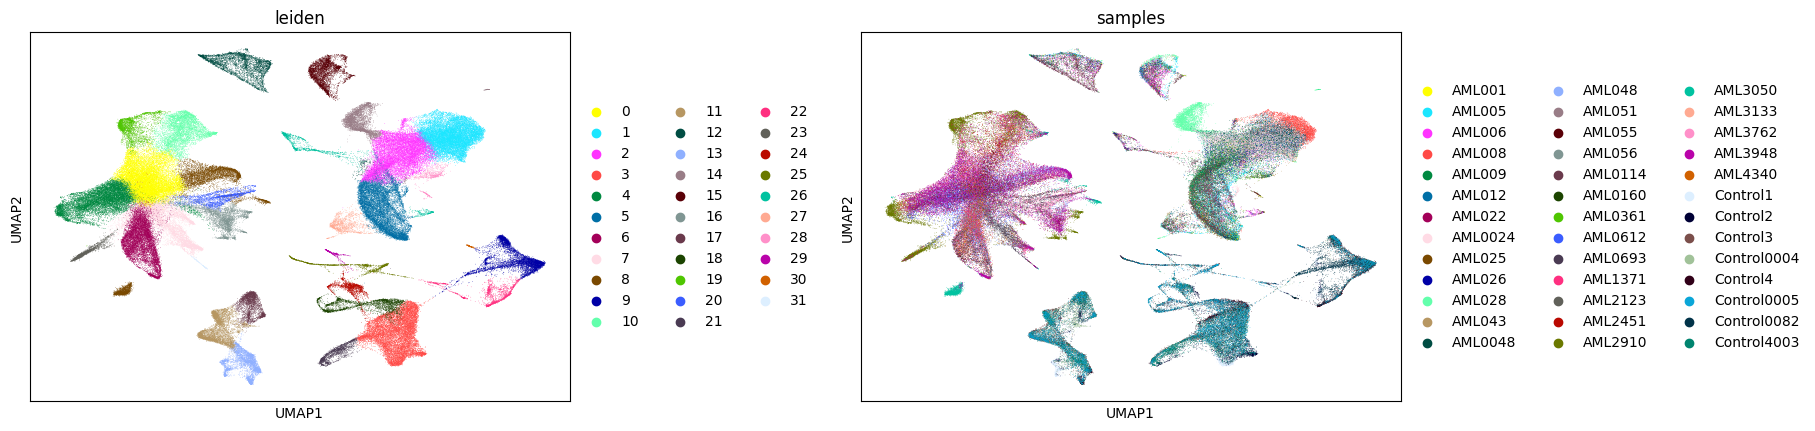

In [4]:
import scanpy as sc
import numpy as np

# Assuming trainGene is your AnnData object
print(f"Original data shape: {trainGene.shape}")

# Basic preprocessing still needed
sc.pp.normalize_total(trainGene, target_sum=1e4)
sc.pp.log1p(trainGene)

# Instead of performing PCA, we'll use the precomputed X_integrated.cca embeddings
# First, let's check if these embeddings exist
if 'X_integrated.cca' in trainGene.obsm:
    print(f"Found integrated.cca embeddings with shape: {trainGene.obsm['X_integrated.cca'].shape}")
    
    # Build neighborhood graph directly from the integrated.cca embeddings
    # We set use_rep='X_integrated.cca' to use these embeddings instead of PCA
    sc.pp.neighbors(
        trainGene, 
        n_neighbors=15, 
        use_rep='X_integrated.cca'  # This is the key part - use CCA embeddings
    )
    
    # Perform Leiden clustering on the neighborhood graph
    sc.tl.leiden(trainGene, resolution=1.0)
    
    print(f"Number of clusters using integrated.cca embeddings: {trainGene.obs['leiden'].nunique()}")
    
    # Compute UMAP using the same integrated embeddings for visualization
    sc.tl.umap(trainGene, min_dist=0.3)
    
    # Plot the UMAP colored by leiden clusters
    sc.pl.umap(trainGene, color=['leiden', 'samples'], wspace=0.4)
    
   
    
else:
    print("Error: X_integrated.cca embeddings not found in the AnnData object")
    # Fallback to the original PCA-based workflow
    sc.pp.highly_variable_genes(trainGene, n_top_genes=2000, batch_key="samples")
    trainGene = trainGene[:, trainGene.var.highly_variable].copy()
    sc.pp.scale(trainGene, max_value=10)
    sc.tl.pca(trainGene, n_comps=50, svd_solver="arpack")
    sc.pp.neighbors(trainGene, n_neighbors=15, n_pcs=50)
    sc.tl.leiden(trainGene, resolution=1.0)

## 3. Preprocess ADT Data

## 3. Centered Log-Ratio (CLR) Normalization for ADT Data

Before we apply standard preprocessing steps, we'll perform Centered Log-Ratio (CLR) normalization on the ADT data. CLR normalization is particularly suited for ADT/CITE-seq data because:

1. It handles the compositional nature of the data
2. It preserves relative differences between markers
3. It reduces technical noise while maintaining biological signal

The CLR transformation is defined as:

$$\text{CLR}(x) = \log(x) - \frac{1}{D}\sum_{i=1}^{D}\log(x_i)$$

Where $D$ is the number of features (ADT markers).

Applying CLR normalization to ADT data...
CLR normalization complete. Shape: (158179, 279)


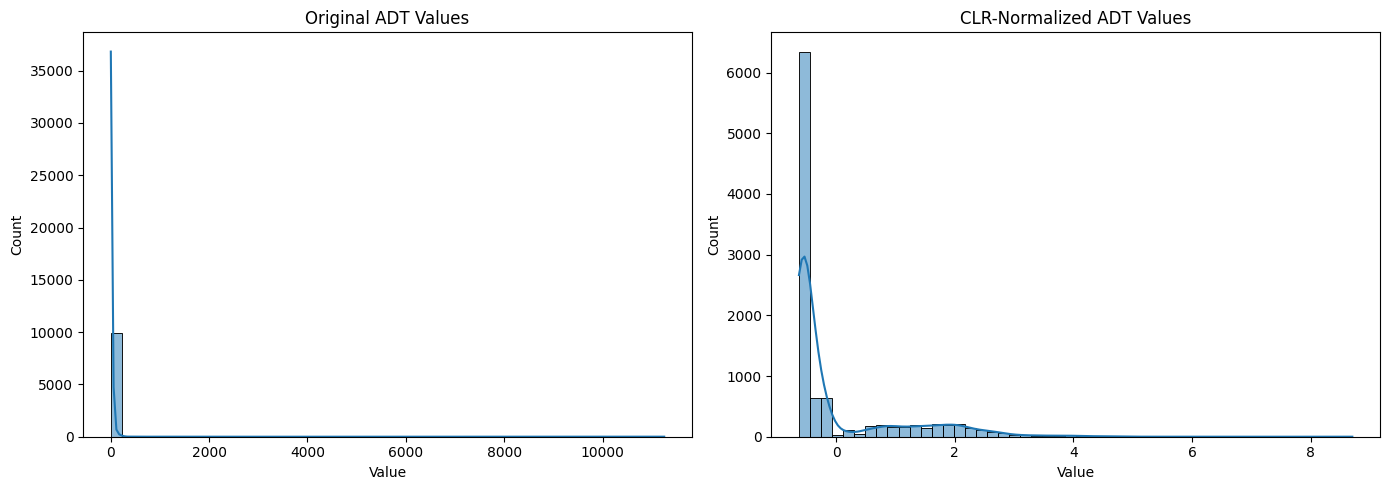

ADT data now uses CLR normalization
ADT data shape: (158179, 279)


In [5]:
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
def clr_normalize(adata, axis=1, pseudo_count=1):
    """
    Apply centered log-ratio normalization to the data.
    
    Parameters:
    -----------
    adata : AnnData
        AnnData object with raw counts
    axis : int, default=1
        0 = normalize features (columns), 1 = normalize cells (rows)
    pseudo_count : float, default=1
        Value to add to counts before log transform to avoid log(0)
        
    Returns:
    --------
    AnnData with CLR-normalized values in .X
    """
    print("Applying CLR normalization to ADT data...")
    
    # Make a copy to avoid modifying the original
    adata_clr = adata.copy()
    
    # Get raw counts (densify if sparse)
    X = adata_clr.X.toarray() if scipy.sparse.issparse(adata_clr.X) else adata_clr.X.copy()
    
    # Add pseudo count
    X += pseudo_count
    
    # Calculate geometric mean of each cell (row) or feature (column)
    if axis == 1:  # across features (for each cell)
        # Get geometric mean for each cell
        geometric_means = np.exp(np.mean(np.log(X), axis=1, keepdims=True))
        # CLR transformation
        X_clr = np.log(X / geometric_means)
    else:  # across cells (for each feature)
        # Get geometric mean for each feature
        geometric_means = np.exp(np.mean(np.log(X), axis=0, keepdims=True))
        # CLR transformation
        X_clr = np.log(X / geometric_means)
    
    # Update data
    adata_clr.X = X_clr
    
    # Store original data in raw slot
    adata_clr.raw = adata
    
    print(f"CLR normalization complete. Shape: {adata_clr.X.shape}")
    return adata_clr

# Apply CLR normalization to ADT data
trainADT_clr = clr_normalize(trainADT)

# Basic quality check - visualize distribution before and after normalization
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Original data distribution
if scipy.sparse.issparse(trainADT.X):
    sample_values = trainADT.X.data[:10000] if len(trainADT.X.data) > 10000 else trainADT.X.data
else:
    sample_values = trainADT.X.flatten()[:10000]
    
sns.histplot(sample_values, bins=50, kde=True, ax=ax[0])
ax[0].set_title("Original ADT Values")
ax[0].set_xlabel("Value")

# CLR-normalized data distribution
sample_values_clr = trainADT_clr.X.flatten()[:10000]
sns.histplot(sample_values_clr, bins=50, kde=True, ax=ax[1])
ax[1].set_title("CLR-Normalized ADT Values")
ax[1].set_xlabel("Value")

plt.tight_layout()
plt.show()

# Replace original ADT data with CLR-normalized data for further processing
trainADT = trainADT_clr

print("ADT data now uses CLR normalization")
print(f"ADT data shape: {trainADT.shape}")

In [8]:
trainGene

AnnData object with n_obs × n_vars = 158179 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'UMAP_1', 'UMAP_2', 'samples', 'Broad_cell_identity', 'Cell_type_identity', 'clusters_res.2', 'CNV_pos', 'malignant', 'aml', 'ap_aml_age', 'age_group', 'sex', 'inflammation_group', 'occupancy_score', 'sample', 'unintegrated_clusters', 'seurat_clusters', 'RNA_snn_res.1', 'source', 'leiden'
    uns: 'log1p', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'samples_colors'
    obsm: 'X_integrated.cca', 'X_pca', 'X_umap', 'X_umap.unintegrated'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

/home/nandivada.s/projects/vanaja_lab/satya/envs/myenv/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
adata.X seems to be already log-transformed.


Original data shape: (90653, 2000)
Found integrated.cca embeddings with shape: (90653, 2)
Number of clusters using integrated.cca embeddings: 103


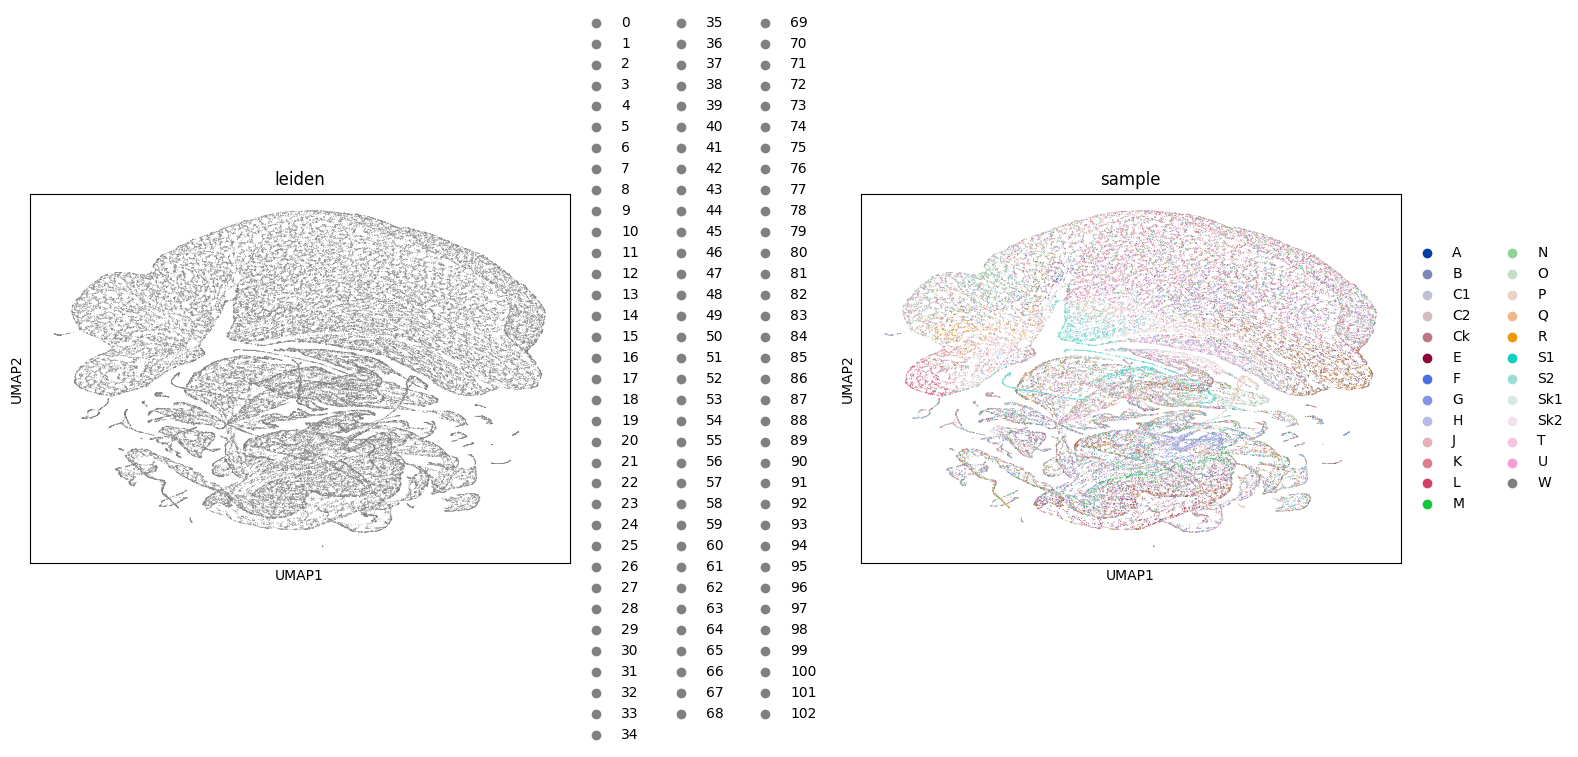

In [15]:
import scanpy as sc
import numpy as np

# Assuming trainGene is your AnnData object
print(f"Original data shape: {GSE120221_ADT.shape}")

# Basic preprocessing still needed
sc.pp.normalize_total(GSE120221_ADT, target_sum=1e4)
sc.pp.log1p(GSE120221_ADT)

# Instead of performing PCA, we'll use the precomputed X_integrated.cca embeddings
# First, let's check if these embeddings exist
if 'X_umap.unintegrated' in GSE120221_ADT.obsm:
    print(f"Found integrated.cca embeddings with shape: {GSE120221_ADT.obsm['X_umap.unintegrated'].shape}")
    
    # Build neighborhood graph directly from the integrated.cca embeddings
    # We set use_rep='X_integrated.cca' to use these embeddings instead of PCA
    sc.pp.neighbors(
        GSE120221_ADT, 
        n_neighbors=15, 
        use_rep='X_umap.unintegrated'  # This is the key part - use CCA embeddings
    )
    
    # Perform Leiden clustering on the neighborhood graph
    sc.tl.leiden(GSE120221_ADT, resolution=1.0)
    
    print(f"Number of clusters using integrated.cca embeddings: {GSE120221_ADT.obs['leiden'].nunique()}")
    
    # Compute UMAP using the same integrated embeddings for visualization
    sc.tl.umap(GSE120221_ADT, min_dist=0.3)
    
    # Plot the UMAP colored by leiden clusters
    sc.pl.umap(GSE120221_ADT, color=['leiden', 'sample'], wspace=0.4)
    
   
    
else:
    print("Error: X_integrated.cca embeddings not found in the AnnData object")
    # Fallback to the original PCA-based workflow
    sc.pp.highly_variable_genes(GSE120221_ADT, n_top_genes=2000, batch_key="samples")
    trainGene = GSE120221_ADT[:, GSE120221_ADT.var.highly_variable].copy()
    sc.pp.scale(GSE120221_ADT, max_value=10)
    sc.tl.pca(GSE120221_ADT, n_comps=50, svd_solver="arpack")
    sc.pp.neighbors(GSE120221_ADT, n_neighbors=15, n_pcs=50)
    sc.tl.leiden(GSE120221_ADT, resolution=1.0)

In [ ]:
## 4. Additional ADT Preprocessing

## 5. Build PyTorch Geometric Data Objects

In [ ]:
from scripts.Embeddings_extract import process_data_with_graphs
rna_data, adt_data, config = process_data_with_graphs(
    trainGene, trainADT,
    n_neighbors=20,
    rna_sparse_threshold=10000000,
    adt_max_edges_sparse=75
)

## 6. Define GAT Model

In [11]:
# Complete setup for your specific data
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from scripts.GATmodel import SimpleGAT, GAT

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Get model parameters from your PyG data
rna_input_dim = rna_data.num_node_features  # 50
adt_input_dim = adt_data.num_node_features  # 50
rna_num_classes = int(rna_data.y.max().item() + 1)
adt_num_classes = int(adt_data.y.max().item() + 1)

print(f"RNA GAT: {rna_input_dim} -> {rna_num_classes} classes")
print(f"ADT GAT: {adt_input_dim} -> {adt_num_classes} classes")

# Create models (using SimpleGAT for memory efficiency with large graphs)
rna_gat_model = SimpleGAT(
    in_channels=rna_input_dim,
    hidden_channels=64,
    out_channels=rna_num_classes,
    heads=4,
    dropout=0.6
).to(device)

adt_gat_model = SimpleGAT(
    in_channels=adt_input_dim,
    hidden_channels=64,
    out_channels=adt_num_classes,
    heads=4,
    dropout=0.6
).to(device)

print("GAT models created successfully!")
print(f"RNA GAT model: {rna_gat_model}")
print(f"ADT GAT model: {adt_gat_model}")

Using device: cpu
RNA GAT: 50 -> 32 classes
ADT GAT: 50 -> 55 classes
GAT models created successfully!
RNA GAT model: SimpleGAT(
  (conv1): GATConv(50, 32, heads=4)
)
ADT GAT model: SimpleGAT(
  (conv1): GATConv(50, 55, heads=4)
)


## 7. Train GAT Models

In [12]:
# Import the training function
from scripts.TrainGAT import train_gat_model

# Train GAT models for both RNA and ADT with memory management
print("=== Training RNA GAT ===")
try:
    rna_trained_model, rna_data_with_masks = train_gat_model(rna_data, "RNA GAT", epochs=200)
except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print("GPU memory insufficient for RNA GAT, trying CPU...")
        rna_trained_model, rna_data_with_masks = train_gat_model(rna_data, "RNA GAT", epochs=200, use_cpu_fallback=True)
    else:
        raise e

print("\n=== Training ADT GAT ===")
try:
    adt_trained_model, adt_data_with_masks = train_gat_model(adt_data, "ADT GAT", epochs=200)
except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print("GPU memory insufficient for ADT GAT, trying CPU...")
        adt_trained_model, adt_data_with_masks = train_gat_model(adt_data, "ADT GAT", epochs=200, use_cpu_fallback=True)
    else:
        raise e

print("\n=== GAT Training Complete ===")
print(f"RNA GAT model trained successfully")
print(f"ADT GAT model trained successfully")

=== Training RNA GAT ===


NameError: name 'rna_data' is not defined

## 8. Extract GAT Embeddings

## 9. Define Transformer Encoder Mapping Model

## 9. Prepare Training Data for Transformer

## 11. Evaluate Transformer Model

## 12. Visualize Results

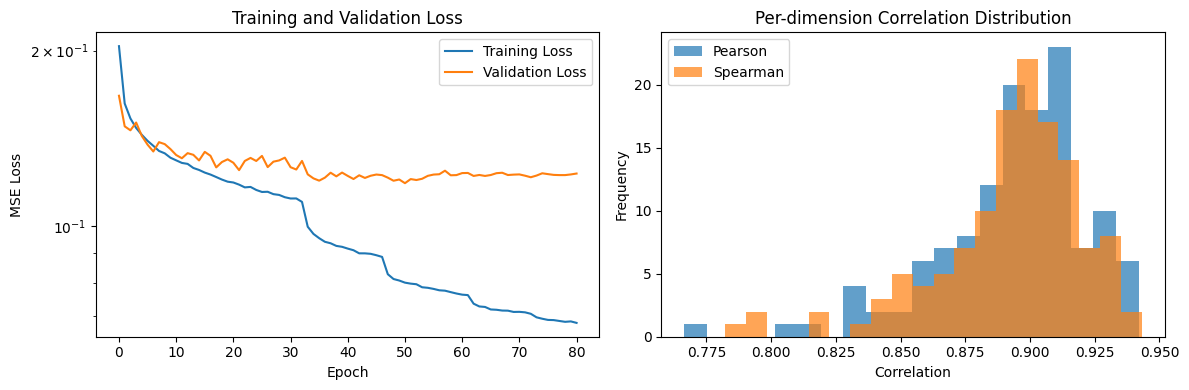

In [15]:
# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.hist(pearson_corrs, bins=20, alpha=0.7, label='Pearson')
plt.hist(spearman_corrs, bins=20, alpha=0.7, label='Spearman')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.title('Per-dimension Correlation Distribution')
plt.legend()

plt.tight_layout()
plt.show()

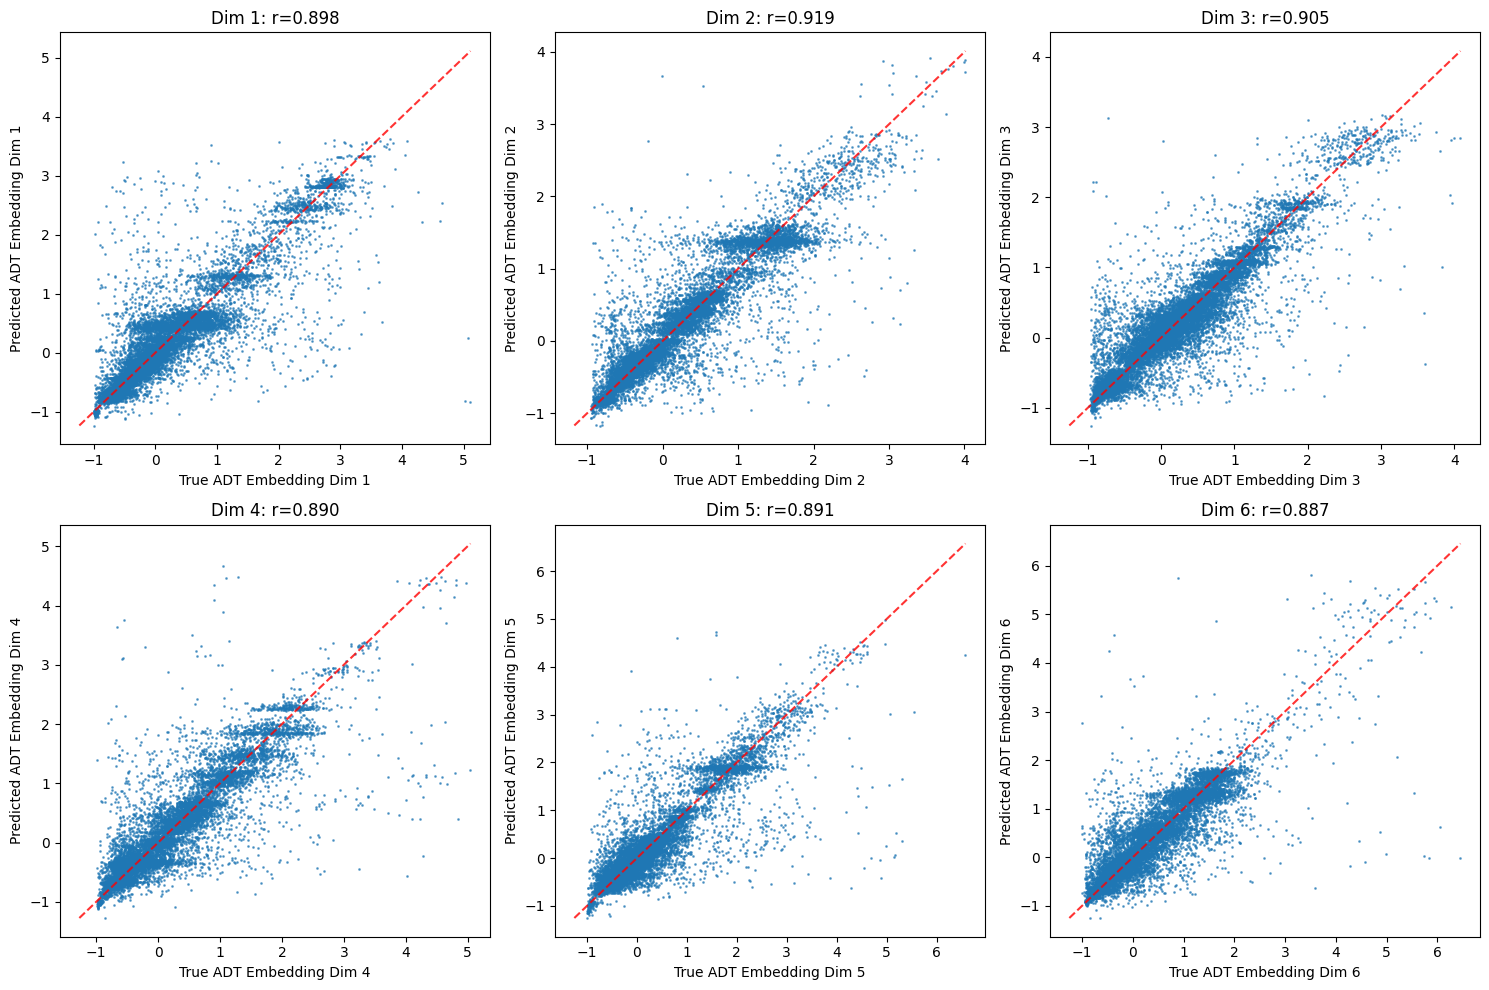

In [20]:
# Scatter plots for first few dimensions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(6, ground_truth.shape[1])):
    ax = axes[i]
    ax.scatter(ground_truth[:, i], predictions[:, i], alpha=0.6, s=1)
    
    # Add perfect prediction line
    min_val = min(ground_truth[:, i].min(), predictions[:, i].min())
    max_val = max(ground_truth[:, i].max(), predictions[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    
    ax.set_xlabel(f'True ADT Embedding Dim {i+1}')
    ax.set_ylabel(f'Predicted ADT Embedding Dim {i+1}')
    ax.set_title(f'Dim {i+1}: r={pearson_corrs[i]:.3f}')

plt.tight_layout()
plt.show()

## 14. Save Models and Results

In [16]:
# Save trained models
torch.save({
    'rna_gat_state_dict': rna_gat_model.state_dict(),
    'adt_gat_state_dict': adt_gat_model.state_dict(),
    'transformer_mapping_state_dict': transformer_model.state_dict(),
    'rna_input_dim': input_dim,
    'adt_output_dim': output_dim,
    'test_results': {
        'mse': mse,
        'r2': r2,
        'mean_pearson': mean_pearson,
        'mean_spearman': mean_spearman,
        'pearson_corrs': pearson_corrs,
        'spearman_corrs': spearman_corrs
    }
}, 'rna_adt_transformer_mapping_models.pth')

print("Models and results saved to 'rna_adt_transformer_mapping_models.pth'")

# Save predictions for further analysis
np.savez('transformer_mapping_predictions.npz', 
         predictions=predictions, 
         ground_truth=ground_truth,
         pearson_corrs=pearson_corrs,
         spearman_corrs=spearman_corrs)

print("Predictions saved to 'transformer_mapping_predictions.npz'")

Models and results saved to 'rna_adt_transformer_mapping_models.pth'
Predictions saved to 'transformer_mapping_predictions.npz'


## 15. Evaluate Cluster Preservation

To further evaluate the quality of the transformer encoder mapping, we can check if the predicted ADT embeddings preserve the cluster structure of the original ADT data. We'll apply Leiden clustering to both the true ADT embeddings and predicted ADT embeddings, then measure the agreement between these cluster assignments.

Evaluating cluster preservation in predicted embeddings...
   Resolution  True Clusters  Predicted Clusters       ARI       NMI
0         0.2             39                  46  0.587389  0.774621
1         0.5             55                  57  0.638965  0.799318
2         0.8             63                  69  0.614643  0.798562
3         1.0             66                  77  0.611639  0.799063
4         1.5             75                  88  0.564618  0.790540
5         2.0             80                  98  0.548566  0.787985


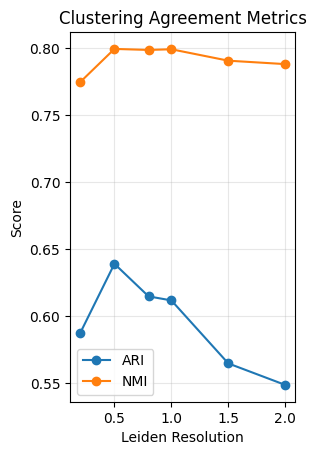

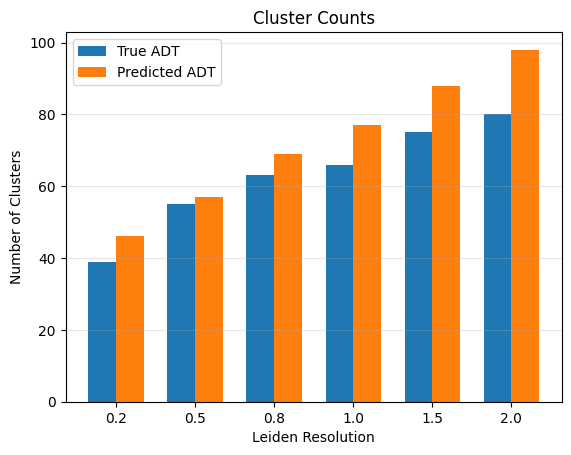


Best resolution: 0.5 (ARI: 0.6390)


<Figure size 640x480 with 0 Axes>

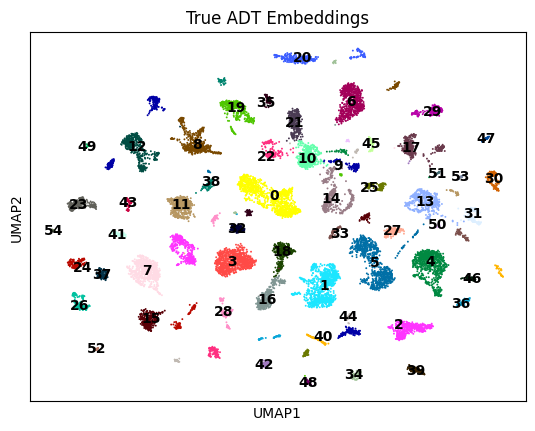

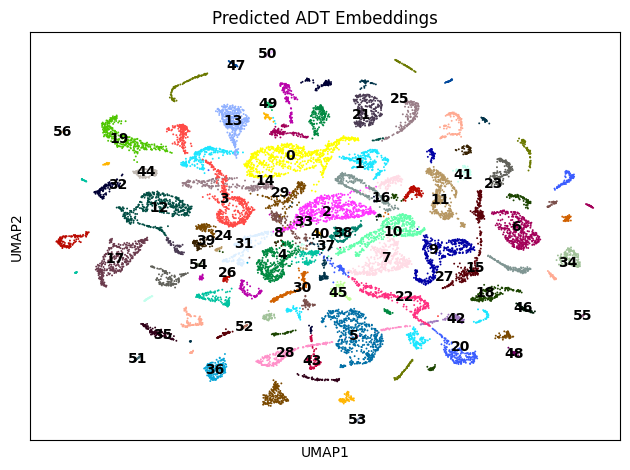

In [17]:
# Create AnnData objects for true and predicted ADT embeddings
import anndata as ad
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import scanpy as sc

print("Evaluating cluster preservation in predicted embeddings...")

# Create AnnData objects
true_adt_adata = ad.AnnData(X=ground_truth)
pred_adt_adata = ad.AnnData(X=predictions)

# Process both datasets the same way
for adata in [true_adt_adata, pred_adt_adata]:
    sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
    
# Run Leiden clustering with multiple resolutions
resolutions = [0.2, 0.5, 0.8, 1.0, 1.5, 2.0]
results = []

for res in resolutions:
    # Cluster true ADT embeddings
    sc.tl.leiden(true_adt_adata, resolution=res, key_added=f'leiden_res{res}')
    
    # Cluster predicted ADT embeddings
    sc.tl.leiden(pred_adt_adata, resolution=res, key_added=f'leiden_res{res}')
    
    # Get cluster labels
    true_labels = true_adt_adata.obs[f'leiden_res{res}'].astype(int).values
    pred_labels = pred_adt_adata.obs[f'leiden_res{res}'].astype(int).values
    
    # Calculate metrics
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels, average_method='arithmetic')
    
    # Number of clusters
    true_n_clusters = len(np.unique(true_labels))
    pred_n_clusters = len(np.unique(pred_labels))
    
    # Store results
    results.append({
        'Resolution': res,
        'True Clusters': true_n_clusters,
        'Predicted Clusters': pred_n_clusters,
        'ARI': ari,
        'NMI': nmi
    })

# Create results dataframe
results_df = pd.DataFrame(results)
print(results_df)

# Visualize results
plt.figure()

plt.subplot(1, 2, 1)
plt.plot(results_df['Resolution'], results_df['ARI'], 'o-', label='ARI')
plt.plot(results_df['Resolution'], results_df['NMI'], 'o-', label='NMI')
plt.xlabel('Leiden Resolution')
plt.ylabel('Score')
plt.title('Clustering Agreement Metrics')
plt.legend()
plt.grid(alpha=0.3)

plt.figure()
bar_width = 0.35
x = np.arange(len(resolutions))
plt.bar(x - bar_width/2, results_df['True Clusters'], bar_width, label='True ADT')
plt.bar(x + bar_width/2, results_df['Predicted Clusters'], bar_width, label='Predicted ADT')
plt.xlabel('Leiden Resolution')
plt.ylabel('Number of Clusters')
plt.title('Cluster Counts')
plt.xticks(x, resolutions)
plt.legend()
plt.grid(alpha=0.3, axis='y')


plt.show()

# Use resolution with best ARI score for UMAP visualization
best_res_idx = results_df['ARI'].idxmax()
best_res = results_df.loc[best_res_idx, 'Resolution']
print(f"\nBest resolution: {best_res} (ARI: {results_df.loc[best_res_idx, 'ARI']:.4f})")

# UMAP visualization of both embeddings with cluster labels
for adata in [true_adt_adata, pred_adt_adata]:
    sc.tl.umap(adata)

# Create a figure for UMAP visualization
plt.figure()


sc.pl.umap(true_adt_adata, color=f'leiden_res{best_res}', title='True ADT Embeddings', show=False, legend_loc='on data')
plt.axis('on')

sc.pl.umap(pred_adt_adata, color=f'leiden_res{best_res}', title='Predicted ADT Embeddings', show=False, legend_loc='on data')
plt.axis('on')

plt.tight_layout()
plt.show()

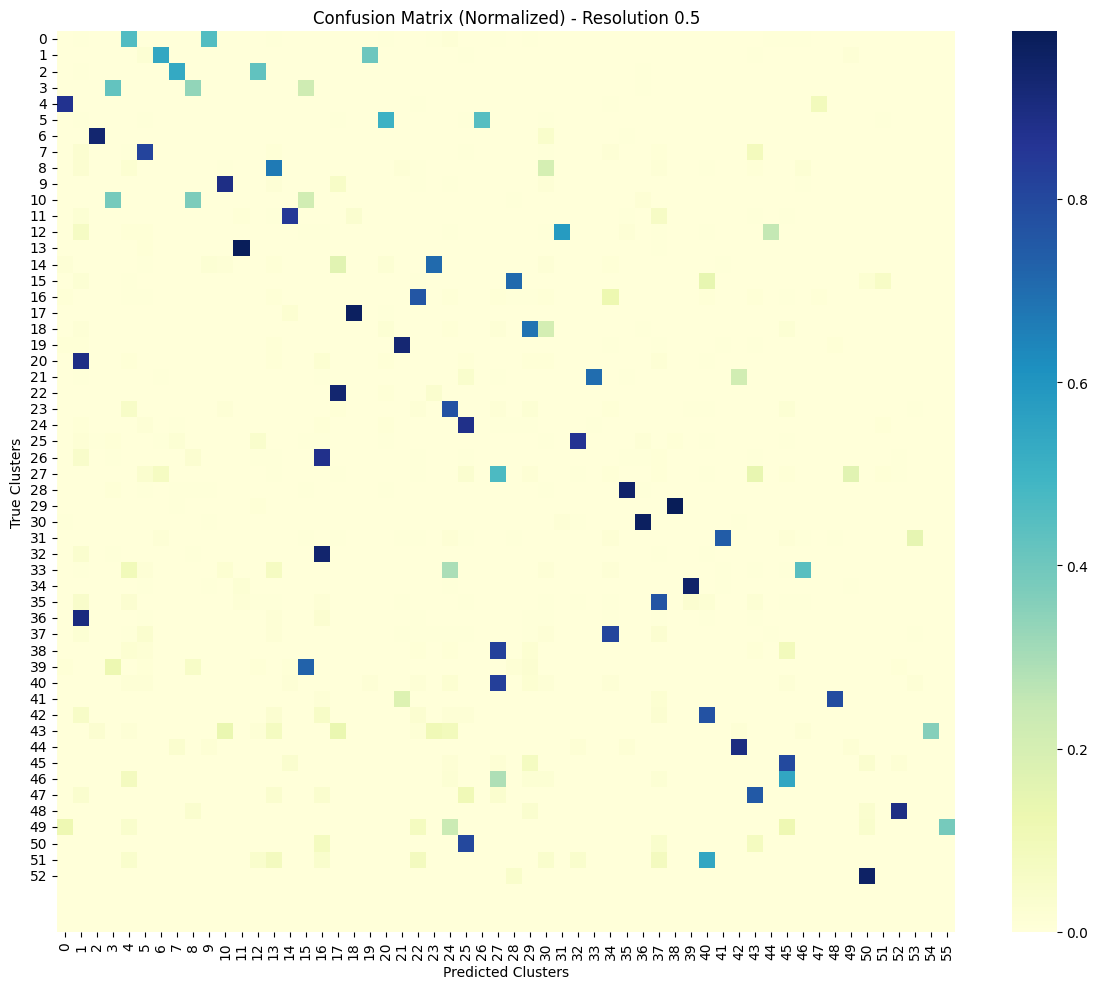

Most preserved cluster: 29 with 98.29% preservation
Least preserved cluster: 53 with 0.00% preservation


/home/nandivada.s/projects/vanaja_lab/satya/envs/myenv/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


<Figure size 1200x1000 with 0 Axes>

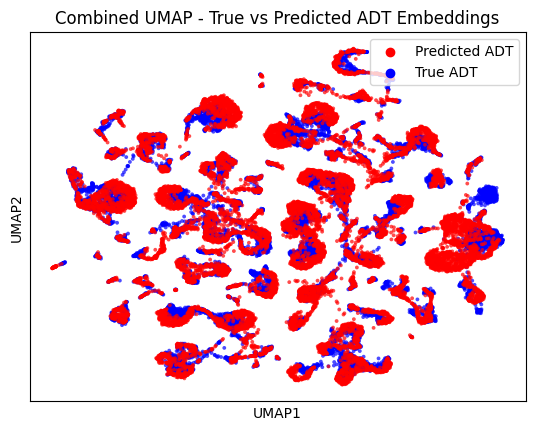


Procrustes analysis disparity (lower is better): 0.9888
This value quantifies how well the global structure is preserved after optimal alignment.

Silhouette score for true clusters: 0.4126
Silhouette score for predicted clusters: 0.5234
Ratio (pred/true): 1.2686
The predicted embeddings have equally good or better defined clusters than the true embeddings.


In [25]:
# Create a confusion matrix to see how well clusters match between true and predicted embeddings
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get cluster labels at the best resolution
best_res = results_df.loc[results_df['ARI'].idxmax(), 'Resolution']
true_labels = true_adt_adata.obs[f'leiden_res{best_res}'].astype(int)
pred_labels = pred_adt_adata.obs[f'leiden_res{best_res}'].astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels, normalize='true')

# Get the number of clusters for proper visualization
n_clusters_true = len(np.unique(true_labels))
n_clusters_pred = len(np.unique(pred_labels))

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True if n_clusters_true <= 20 else False,
            fmt='.2f', xticklabels=range(n_clusters_pred), yticklabels=range(n_clusters_true))
plt.xlabel('Predicted Clusters')
plt.ylabel('True Clusters')
plt.title(f'Confusion Matrix (Normalized) - Resolution {best_res}')
plt.tight_layout()
plt.show()

# Find the most preserved and least preserved clusters
cluster_preservation = np.max(conf_matrix, axis=1)
most_preserved_idx = np.argmax(cluster_preservation)
least_preserved_idx = np.argmin(cluster_preservation)

print(f"Most preserved cluster: {most_preserved_idx} with {cluster_preservation[most_preserved_idx]:.2%} preservation")
print(f"Least preserved cluster: {least_preserved_idx} with {cluster_preservation[least_preserved_idx]:.2%} preservation")

# Add cluster labels to the original data for further analysis
adata_combined = ad.AnnData(
    X=np.concatenate([ground_truth, predictions]),
    obs=pd.DataFrame({
        'embedding_type': ['True ADT'] * ground_truth.shape[0] + ['Predicted ADT'] * predictions.shape[0],
    })
)

# Calculate UMAP for the combined embedding space
sc.pp.neighbors(adata_combined, n_neighbors=15, use_rep='X')
sc.tl.umap(adata_combined)

# Plot combined UMAP
plt.figure(figsize=(12, 10))
sc.pl.umap(adata_combined, color='embedding_type', title='Combined UMAP - True vs Predicted ADT Embeddings',
           palette={'True ADT': 'blue', 'Predicted ADT': 'red'}, alpha=0.7, size=30, show=False)
plt.legend(loc='upper right', frameon=True)
plt.show()

# Quantify global structure preservation
from scipy.spatial import procrustes

# Perform Procrustes analysis on UMAP coordinates
true_coords = true_adt_adata.obsm['X_umap']
pred_coords = pred_adt_adata.obsm['X_umap']

# Procrustes analysis scales, rotates and translates the predicted coordinates to best match the true coordinates
mtx1, mtx2, disparity = procrustes(true_coords, pred_coords)

print(f"\nProcrustes analysis disparity (lower is better): {disparity:.4f}")
print("This value quantifies how well the global structure is preserved after optimal alignment.")

# Calculate silhouette scores to measure cluster quality
from sklearn.metrics import silhouette_score

try:
    true_silhouette = silhouette_score(true_adt_adata.X, true_labels)
    pred_silhouette = silhouette_score(pred_adt_adata.X, pred_labels)
    
    print(f"\nSilhouette score for true clusters: {true_silhouette:.4f}")
    print(f"Silhouette score for predicted clusters: {pred_silhouette:.4f}")
    print(f"Ratio (pred/true): {pred_silhouette/true_silhouette:.4f}")
    if pred_silhouette >= true_silhouette:
        print("The predicted embeddings have equally good or better defined clusters than the true embeddings.")
    else:
        print("The true embeddings have better defined clusters than the predicted embeddings.")
except:
    print("Could not calculate silhouette scores, possibly due to cluster numbers or sample size.")

## 16. Interpretation of Cluster Preservation Results

The above analysis helps us understand how well our Transformer Encoder model preserves biological cell types when mapping from RNA to ADT embeddings. Here's how to interpret these results:

### Key Metrics:
- **Adjusted Rand Index (ARI)**: Measures the similarity between the true and predicted cluster assignments, adjusted for chance. Values range from -1 to 1, where 1 indicates perfect agreement, and values near 0 indicate random clustering.
- **Normalized Mutual Information (NMI)**: Quantifies the shared information between the two clusterings. Values range from 0 to 1, with 1 indicating perfect agreement.
- **Procrustes Disparity**: Measures how well the global structure is preserved after optimal alignment (lower is better).
- **Silhouette Scores**: Measures how well-defined the clusters are (higher is better).

### Interpretation Guidelines:

1. **Strong Cluster Preservation** (Good model performance):
   - High ARI (> 0.7) and NMI (> 0.8)
   - Similar number of clusters between true and predicted embeddings
   - Low Procrustes disparity
   - Similar silhouette scores between true and predicted embeddings
   - Clear diagonal pattern in confusion matrix

2. **Moderate Cluster Preservation** (Acceptable model performance):
   - Moderate ARI (0.4-0.7) and NMI (0.5-0.8)
   - Some differences in cluster numbers
   - Some off-diagonal elements in confusion matrix, but still showing structure
   - Visible separation of clusters in UMAP visualizations, though not identical

3. **Poor Cluster Preservation** (Model needs improvement):
   - Low ARI (< 0.4) and NMI (< 0.5)
   - Very different number of clusters
   - No clear pattern in confusion matrix
   - Poor separation in UMAP visualizations

### Biological Significance:
If the model demonstrates good cluster preservation, it suggests that:
1. The RNA expression data contains sufficient information to predict cell types as defined by surface protein markers
2. The transformer model has successfully learned to map between these two modalities
3. The predicted ADT embeddings could potentially be used for downstream analyses in place of actual ADT measurements

This evaluation framework provides a comprehensive assessment of how well the model maintains biological cell type structure when mapping between RNA and ADT modalities.

## Summary

This notebook implements a pipeline to learn mappings between GAT embeddings of RNA and ADT data:

1. **Data Preprocessing**: Both RNA and ADT data are normalized, scaled, and processed to create neighbor graphs
2. **GAT Training**: Separate GAT models are trained on RNA and ADT data for node classification
3. **Embedding Extraction**: Intermediate embeddings are extracted from the trained GAT models
4. **Transformer Mapping**: 
   - A Transformer Encoder architecture learns to map RNA embeddings to ADT embeddings
   - Self-attention mechanisms capture complex dependencies between embedding dimensions
   - Multi-headed attention allows the model to focus on different aspects of the data
5. **Evaluation**: The mapping quality is assessed using MSE, R², and correlation metrics

The Transformer architecture offers several advantages over MLPs:
- **Context awareness**: Self-attention mechanism captures global dependencies in the embeddings
- **Parameter efficiency**: Shared parameters across layers for better generalization
- **Representation power**: Better handling of complex relationships between features

The trained models can be used to predict ADT embeddings from RNA data, enabling cross-modal analysis and integration.

Calculating cell type performance metrics...
Cluster mapping from true to predicted: {0: np.int64(4), 1: np.int64(6), 2: np.int64(7), 3: np.int64(3), 4: np.int64(0), 5: np.int64(20), 6: np.int64(2), 7: np.int64(5), 8: np.int64(13), 9: np.int64(10), 10: np.int64(3), 11: np.int64(14), 12: np.int64(31), 13: np.int64(11), 14: np.int64(23), 15: np.int64(28), 16: np.int64(22), 17: np.int64(18), 18: np.int64(29), 19: np.int64(21), 20: np.int64(1), 21: np.int64(33), 22: np.int64(17), 23: np.int64(24), 24: np.int64(25), 25: np.int64(32), 26: np.int64(16), 27: np.int64(27), 28: np.int64(35), 29: np.int64(38), 30: np.int64(36), 31: np.int64(41), 32: np.int64(16), 33: np.int64(46), 34: np.int64(39), 35: np.int64(37), 36: np.int64(1), 37: np.int64(34), 38: np.int64(27), 39: np.int64(15), 40: np.int64(27), 41: np.int64(48), 42: np.int64(40), 43: np.int64(54), 44: np.int64(42), 45: np.int64(45), 46: np.int64(45), 47: np.int64(43), 48: np.int64(52), 49: np.int64(55), 50: np.int64(25), 51: np.int64(40)

/tmp/ipykernel_1557209/3280600926.py:21: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1, keepdims=True)  # Normalize by row (true clusters)


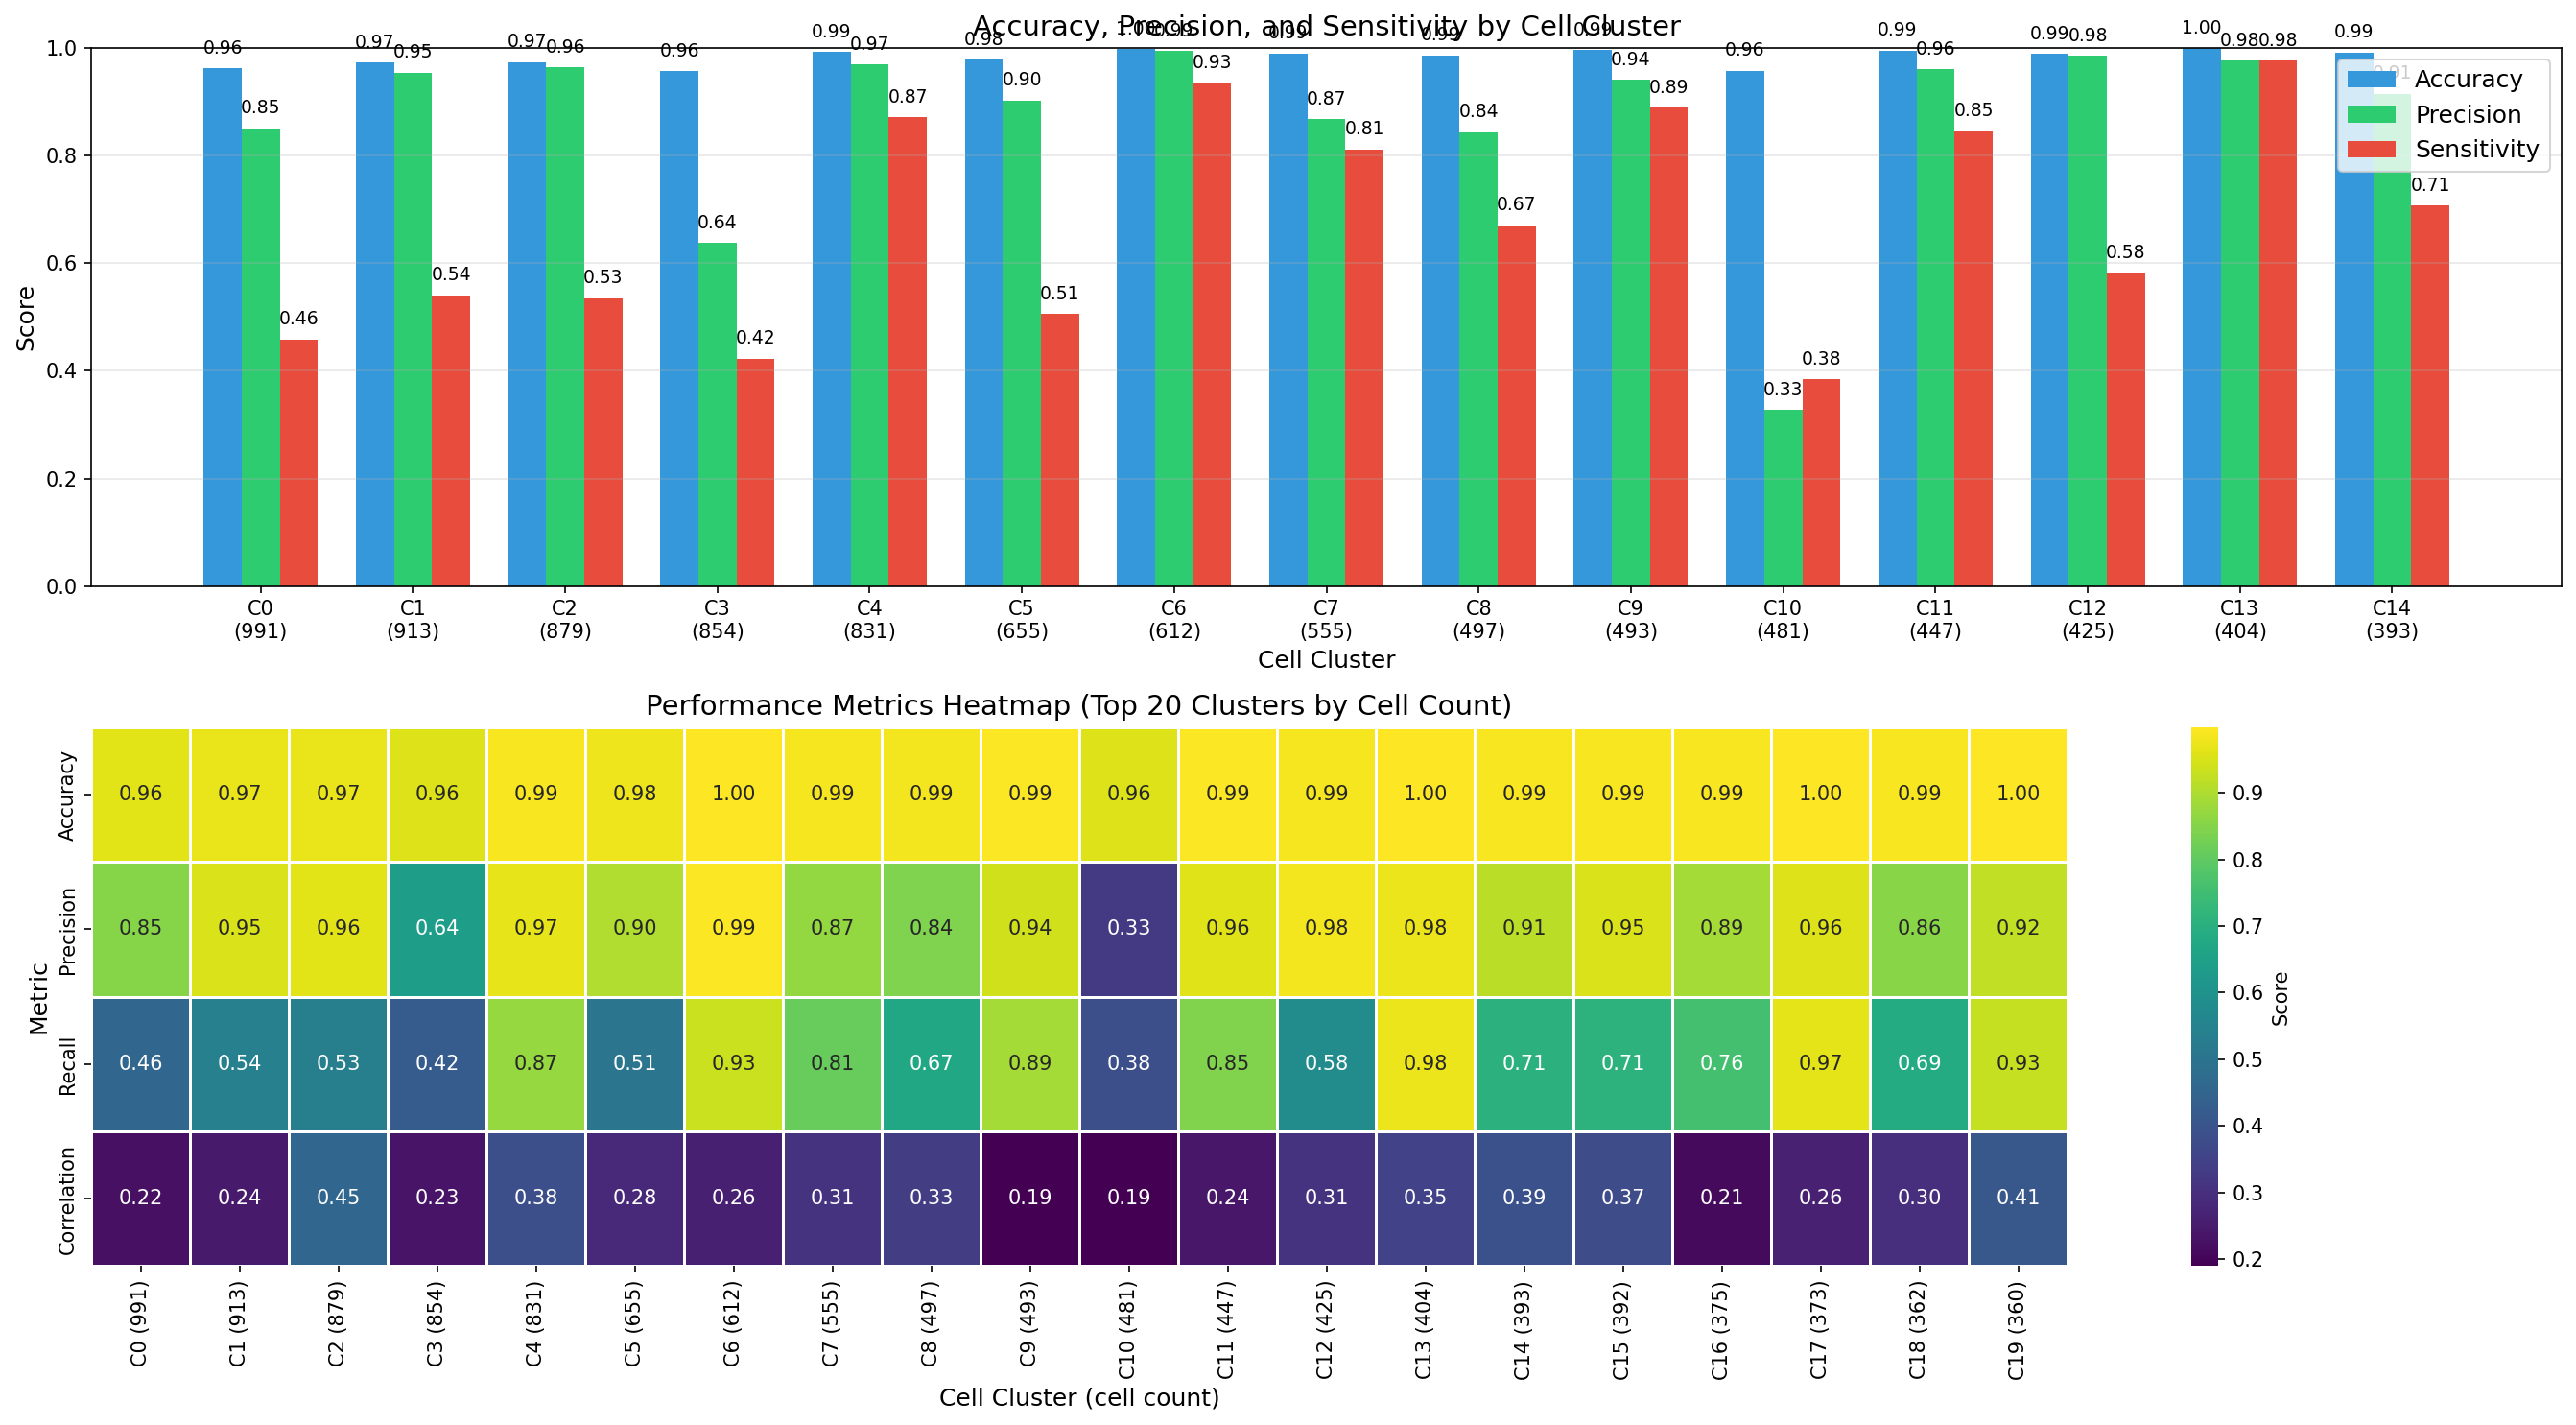

/tmp/ipykernel_1557209/3280600926.py:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbars


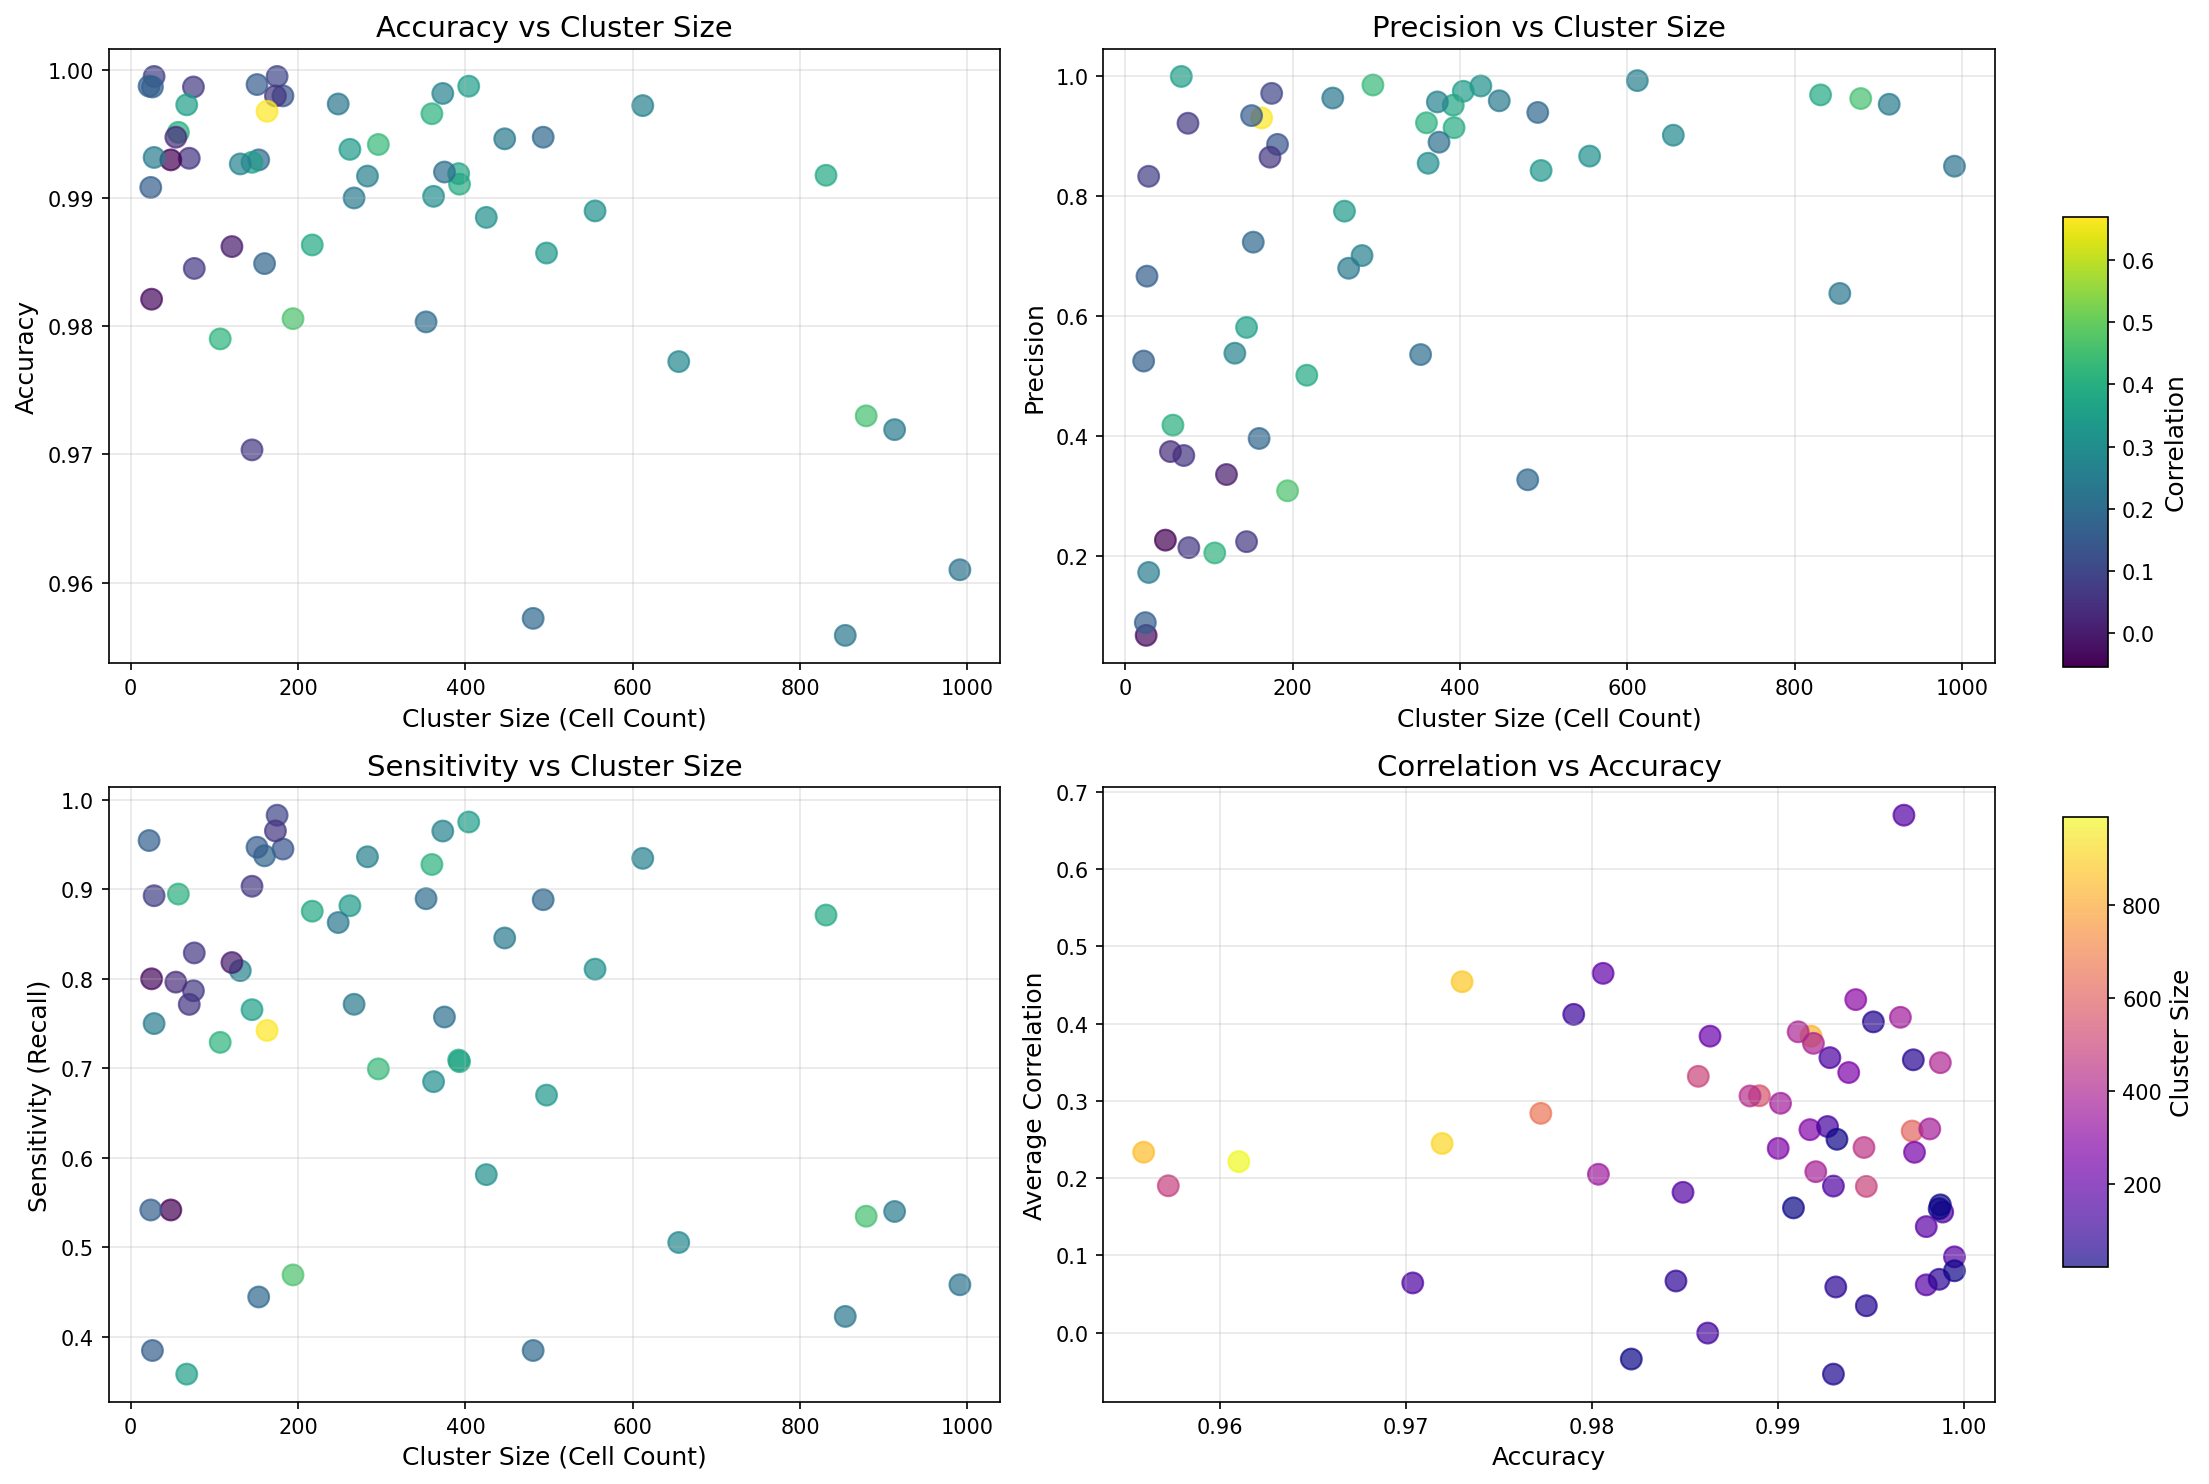


Summary Statistics for Cell Type Performance:
Overall Mean Accuracy: 0.9891
Overall Mean Precision: 0.6901
Overall Mean Sensitivity: 0.7519
Overall Mean Correlation: 0.2416

Best performing cluster: Cluster 29.0 with 175.0 cells
  Accuracy: 0.9995, Precision: 0.9718, Sensitivity: 0.9829

Worst performing cluster: Cluster 3.0 with 854.0 cells
  Accuracy: 0.9559, Precision: 0.6378, Sensitivity: 0.4227

Metrics saved to 'celltype_performance_metrics.csv'


In [31]:
# Cell Type Performance Metrics: Accuracy, Sensitivity, and Precision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from scipy.stats import pearsonr

print("Calculating cell type performance metrics...")

# First, ensure we have cluster labels from both RNA and ADT data
# We'll use leiden clustering results at the best resolution
best_res = results_df.loc[results_df['ARI'].idxmax(), 'Resolution']

# Get cluster labels for true and predicted data
true_labels = true_adt_adata.obs[f'leiden_res{best_res}'].astype(int).values
pred_labels = pred_adt_adata.obs[f'leiden_res{best_res}'].astype(int).values

# 1. Build a mapping between predicted and true clusters using maximum overlap
cm = confusion_matrix(true_labels, pred_labels)
cm_norm = cm / cm.sum(axis=1, keepdims=True)  # Normalize by row (true clusters)

# For each true cluster, find the predicted cluster with maximum overlap
cluster_mapping = {}
for i in range(cm.shape[0]):
    max_j = np.argmax(cm[i])
    cluster_mapping[i] = max_j

print(f"Cluster mapping from true to predicted: {cluster_mapping}")

# 2. Calculate metrics per cell type (cluster)
metrics = []
unique_clusters = np.unique(true_labels)

for cluster in unique_clusters:
    # Create binary classification problem for this cluster
    true_binary = (true_labels == cluster).astype(int)
    pred_binary = (pred_labels == cluster_mapping[cluster]).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(true_binary, pred_binary)
    precision = precision_score(true_binary, pred_binary, zero_division=0)
    recall = recall_score(true_binary, pred_binary, zero_division=0)
    
    # Calculate correlation for cells in this cluster
    cluster_mask = (true_labels == cluster)
    if np.sum(cluster_mask) > 5:  # Ensure enough samples for correlation
        # Get true and predicted embeddings for this cluster
        true_emb_cluster = ground_truth[cluster_mask]
        pred_emb_cluster = predictions[cluster_mask]
        
        # Calculate average correlation across dimensions
        corr_values = []
        for i in range(true_emb_cluster.shape[1]):
            r, _ = pearsonr(true_emb_cluster[:, i], pred_emb_cluster[:, i])
            corr_values.append(r)
        avg_corr = np.mean(corr_values)
    else:
        avg_corr = np.nan
    
    # Count cells in this cluster
    cell_count = np.sum(cluster_mask)
    
    metrics.append({
        'Cluster': cluster,
        'Cell Count': cell_count,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,  # Same as Sensitivity
        'Correlation': avg_corr,
        'Mapped To': cluster_mapping[cluster]
    })

# Create DataFrame for visualization
metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.sort_values('Cell Count', ascending=False)

# 3. Plot metrics
plt.figure(figsize=(18, 10))

# Plot metrics side by side with custom colors
ax1 = plt.subplot(2, 1, 1)
metrics_subset = metrics_df.sort_values('Cell Count', ascending=False).head(15)  # Top 15 clusters by size

bar_width = 0.25
x = np.arange(len(metrics_subset))

# Plot bars
ax1.bar(x - bar_width, metrics_subset['Accuracy'], bar_width, label='Accuracy', color='#3498db')
ax1.bar(x, metrics_subset['Precision'], bar_width, label='Precision', color='#2ecc71')
ax1.bar(x + bar_width, metrics_subset['Recall'], bar_width, label='Sensitivity', color='#e74c3c')

# Add labels and formatting
ax1.set_xlabel('Cell Cluster', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Accuracy, Precision, and Sensitivity by Cell Cluster', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels([f"C{c}\n({n})" for c, n in zip(metrics_subset['Cluster'], metrics_subset['Cell Count'])])
ax1.legend(fontsize=12)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1)

# Add value labels above bars
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall']):
    for j, value in enumerate(metrics_subset[metric]):
        ax1.text(j + (i-1)*bar_width, value + 0.02, f"{value:.2f}", 
                ha='center', va='bottom', fontsize=9, rotation=0)

# Create a heatmap of all metrics
ax2 = plt.subplot(2, 1, 2)
metrics_plot = metrics_df.sort_values('Cell Count', ascending=False).head(20)
metrics_heatmap = metrics_plot[['Accuracy', 'Precision', 'Recall', 'Correlation']].copy()
metrics_heatmap.index = [f"C{c} ({n})" for c, n in zip(metrics_plot['Cluster'], metrics_plot['Cell Count'])]

sns.heatmap(metrics_heatmap.T, annot=True, fmt='.2f', cmap='viridis', 
            linewidths=0.5, ax=ax2, cbar_kws={'label': 'Score'})
ax2.set_title('Performance Metrics Heatmap (Top 20 Clusters by Cell Count)', fontsize=14)
ax2.set_ylabel('Metric', fontsize=12)
ax2.set_xlabel('Cell Cluster (cell count)', fontsize=12)

plt.tight_layout()
plt.savefig('celltype_performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Create scatter plot showing relationship between cluster size and performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Create colormap based on correlation values
cmap = plt.cm.viridis
norm = plt.Normalize(metrics_df['Correlation'].min(), metrics_df['Correlation'].max())

# Plot Accuracy vs Cluster Size
axes[0, 0].scatter(metrics_df['Cell Count'], metrics_df['Accuracy'],
                   c=metrics_df['Correlation'], cmap=cmap, s=100, alpha=0.7)
axes[0, 0].set_xlabel('Cluster Size (Cell Count)', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Accuracy vs Cluster Size', fontsize=14)
axes[0, 0].grid(alpha=0.3)

# Plot Precision vs Cluster Size
axes[0, 1].scatter(metrics_df['Cell Count'], metrics_df['Precision'],
                   c=metrics_df['Correlation'], cmap=cmap, s=100, alpha=0.7)
axes[0, 1].set_xlabel('Cluster Size (Cell Count)', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision vs Cluster Size', fontsize=14)
axes[0, 1].grid(alpha=0.3)

# Plot Sensitivity vs Cluster Size
axes[1, 0].scatter(metrics_df['Cell Count'], metrics_df['Recall'],
                   c=metrics_df['Correlation'], cmap=cmap, s=100, alpha=0.7)
axes[1, 0].set_xlabel('Cluster Size (Cell Count)', fontsize=12)
axes[1, 0].set_ylabel('Sensitivity (Recall)', fontsize=12)
axes[1, 0].set_title('Sensitivity vs Cluster Size', fontsize=14)
axes[1, 0].grid(alpha=0.3)

# Plot Correlation vs Accuracy
scatter = axes[1, 1].scatter(metrics_df['Accuracy'], metrics_df['Correlation'],
                             c=metrics_df['Cell Count'], cmap='plasma', s=100, alpha=0.7)
axes[1, 1].set_xlabel('Accuracy', fontsize=12)
axes[1, 1].set_ylabel('Average Correlation', fontsize=12)
axes[1, 1].set_title('Correlation vs Accuracy', fontsize=14)
axes[1, 1].grid(alpha=0.3)

# Add a colorbar for correlation in the first 3 plots
cbar_ax1 = fig.add_axes([0.92, 0.55, 0.02, 0.3])  # [left, bottom, width, height]
cb1 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax1)
cb1.set_label('Correlation', fontsize=12)

# Add a colorbar for cluster size in the last plot
cbar_ax2 = fig.add_axes([0.92, 0.15, 0.02, 0.3])  # [left, bottom, width, height]
cb2 = plt.colorbar(scatter, cax=cbar_ax2)
cb2.set_label('Cluster Size', fontsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbars
plt.savefig('celltype_metrics_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Summary statistics
print("\nSummary Statistics for Cell Type Performance:")
print(f"Overall Mean Accuracy: {metrics_df['Accuracy'].mean():.4f}")
print(f"Overall Mean Precision: {metrics_df['Precision'].mean():.4f}")
print(f"Overall Mean Sensitivity: {metrics_df['Recall'].mean():.4f}")
print(f"Overall Mean Correlation: {metrics_df['Correlation'].mean():.4f}")

# Best and worst performing clusters
best_cluster = metrics_df.loc[metrics_df['Accuracy'].idxmax()]
worst_cluster = metrics_df.loc[metrics_df['Accuracy'].idxmin()]

print(f"\nBest performing cluster: Cluster {best_cluster['Cluster']} with {best_cluster['Cell Count']} cells")
print(f"  Accuracy: {best_cluster['Accuracy']:.4f}, Precision: {best_cluster['Precision']:.4f}, Sensitivity: {best_cluster['Recall']:.4f}")

print(f"\nWorst performing cluster: Cluster {worst_cluster['Cluster']} with {worst_cluster['Cell Count']} cells")
print(f"  Accuracy: {worst_cluster['Accuracy']:.4f}, Precision: {worst_cluster['Precision']:.4f}, Sensitivity: {worst_cluster['Recall']:.4f}")

# Save metrics to CSV
metrics_df.to_csv('celltype_performance_metrics.csv', index=False)
print("\nMetrics saved to 'celltype_performance_metrics.csv'")

## Cell Type Label Transfer 

We will now implement cell type label transfer from the true ADT embeddings to the predicted ADT embeddings. This allows us to:

1. Identify cell types in the predicted ADT embeddings
2. Evaluate how well the transformer preserves cell type information
3. Create a pipeline for annotating new RNA data with cell types derived from ADT data

This approach uses a k-nearest neighbor classifier to transfer cell type labels from the true ADT embeddings to the predicted ADT embeddings.

Performing cell type label transfer from true ADT to predicted ADT embeddings...
No explicit cell type annotation found. Using leiden clusters as proxy for cell types.
Found 54 unique cell types/clusters.
Label transfer accuracy: 0.8665
Found 54 unique labels, showing confusion matrix for top 30 most populous classes.


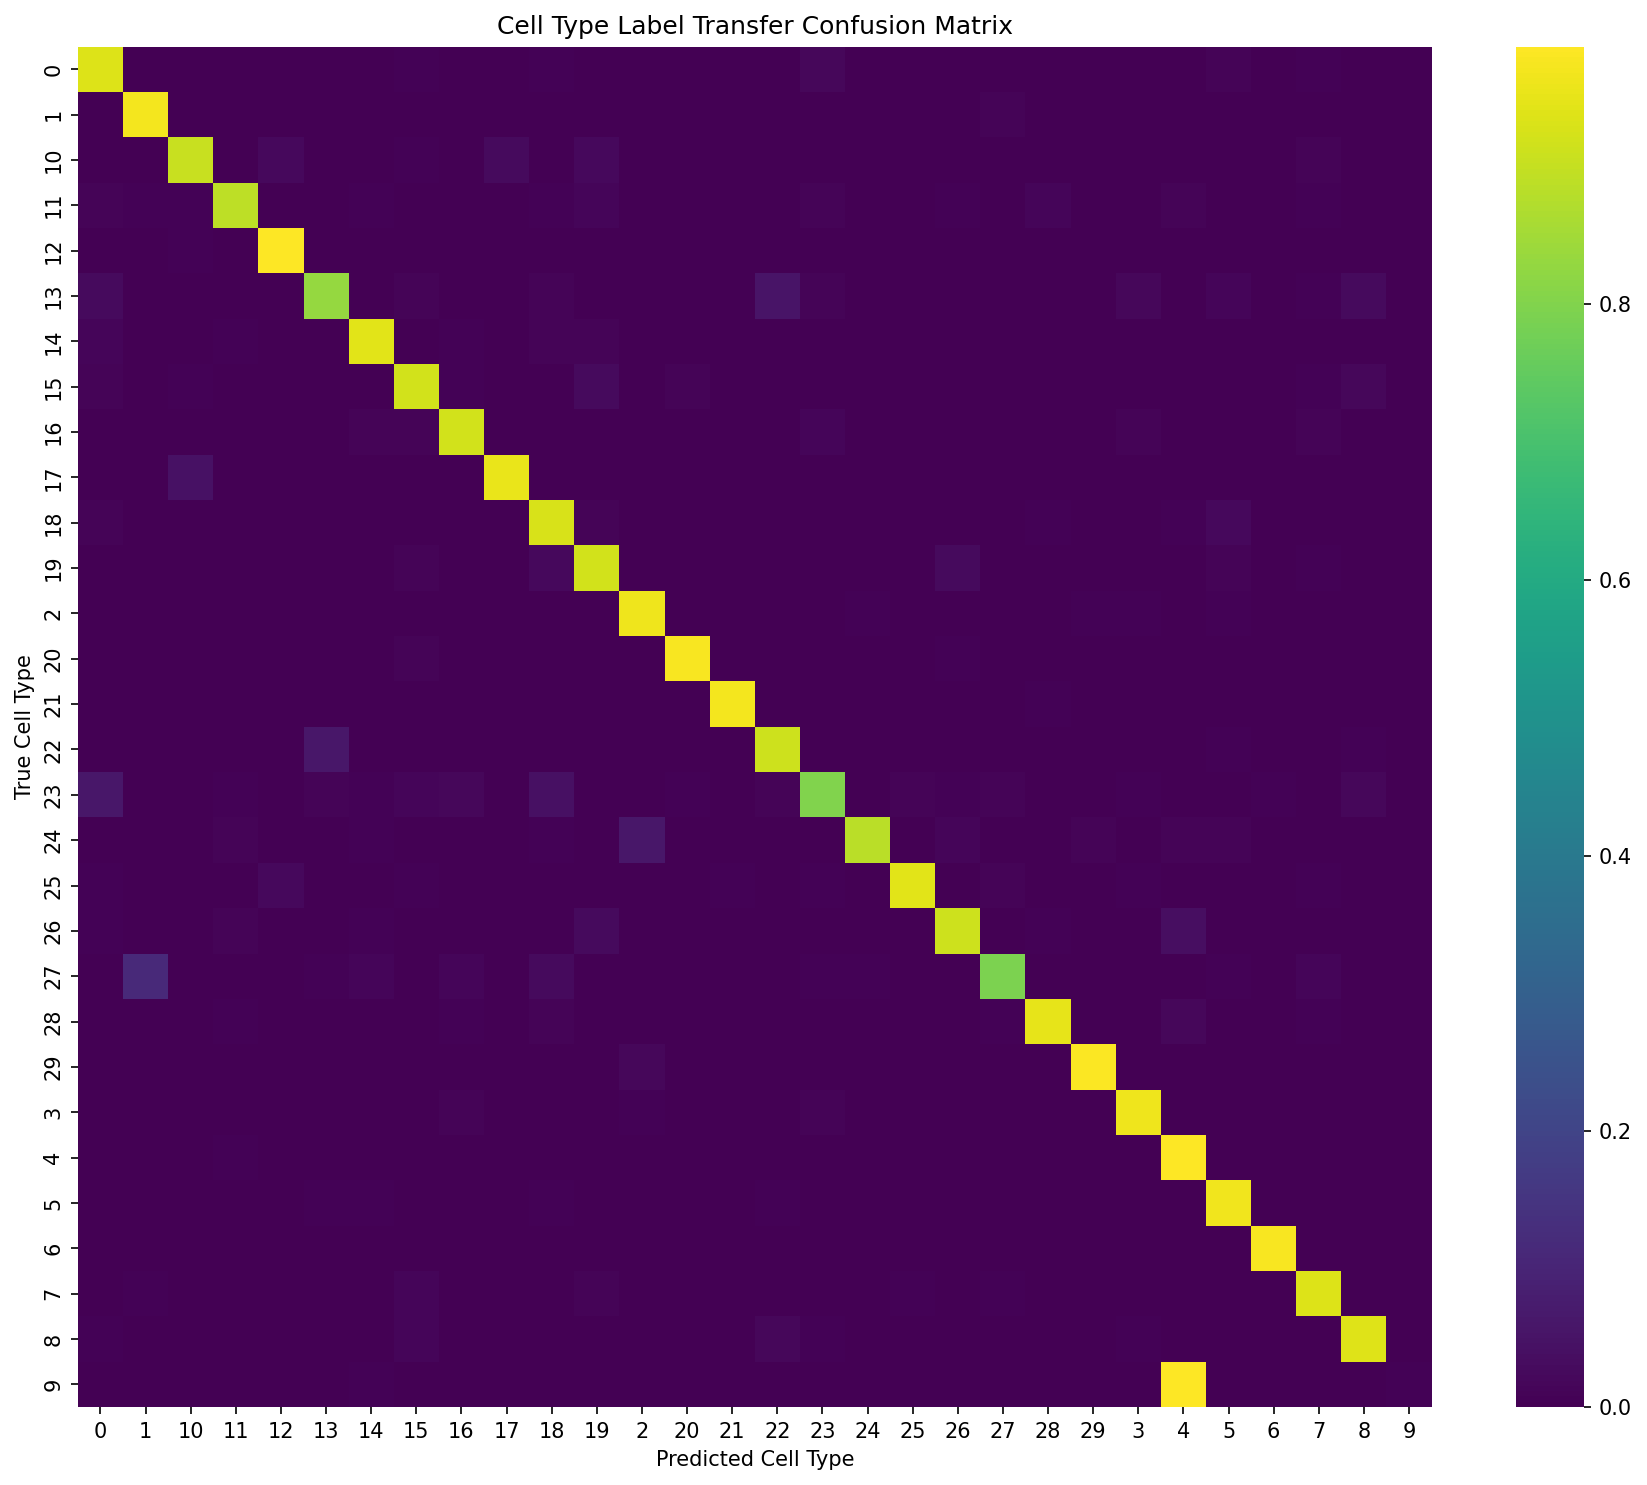

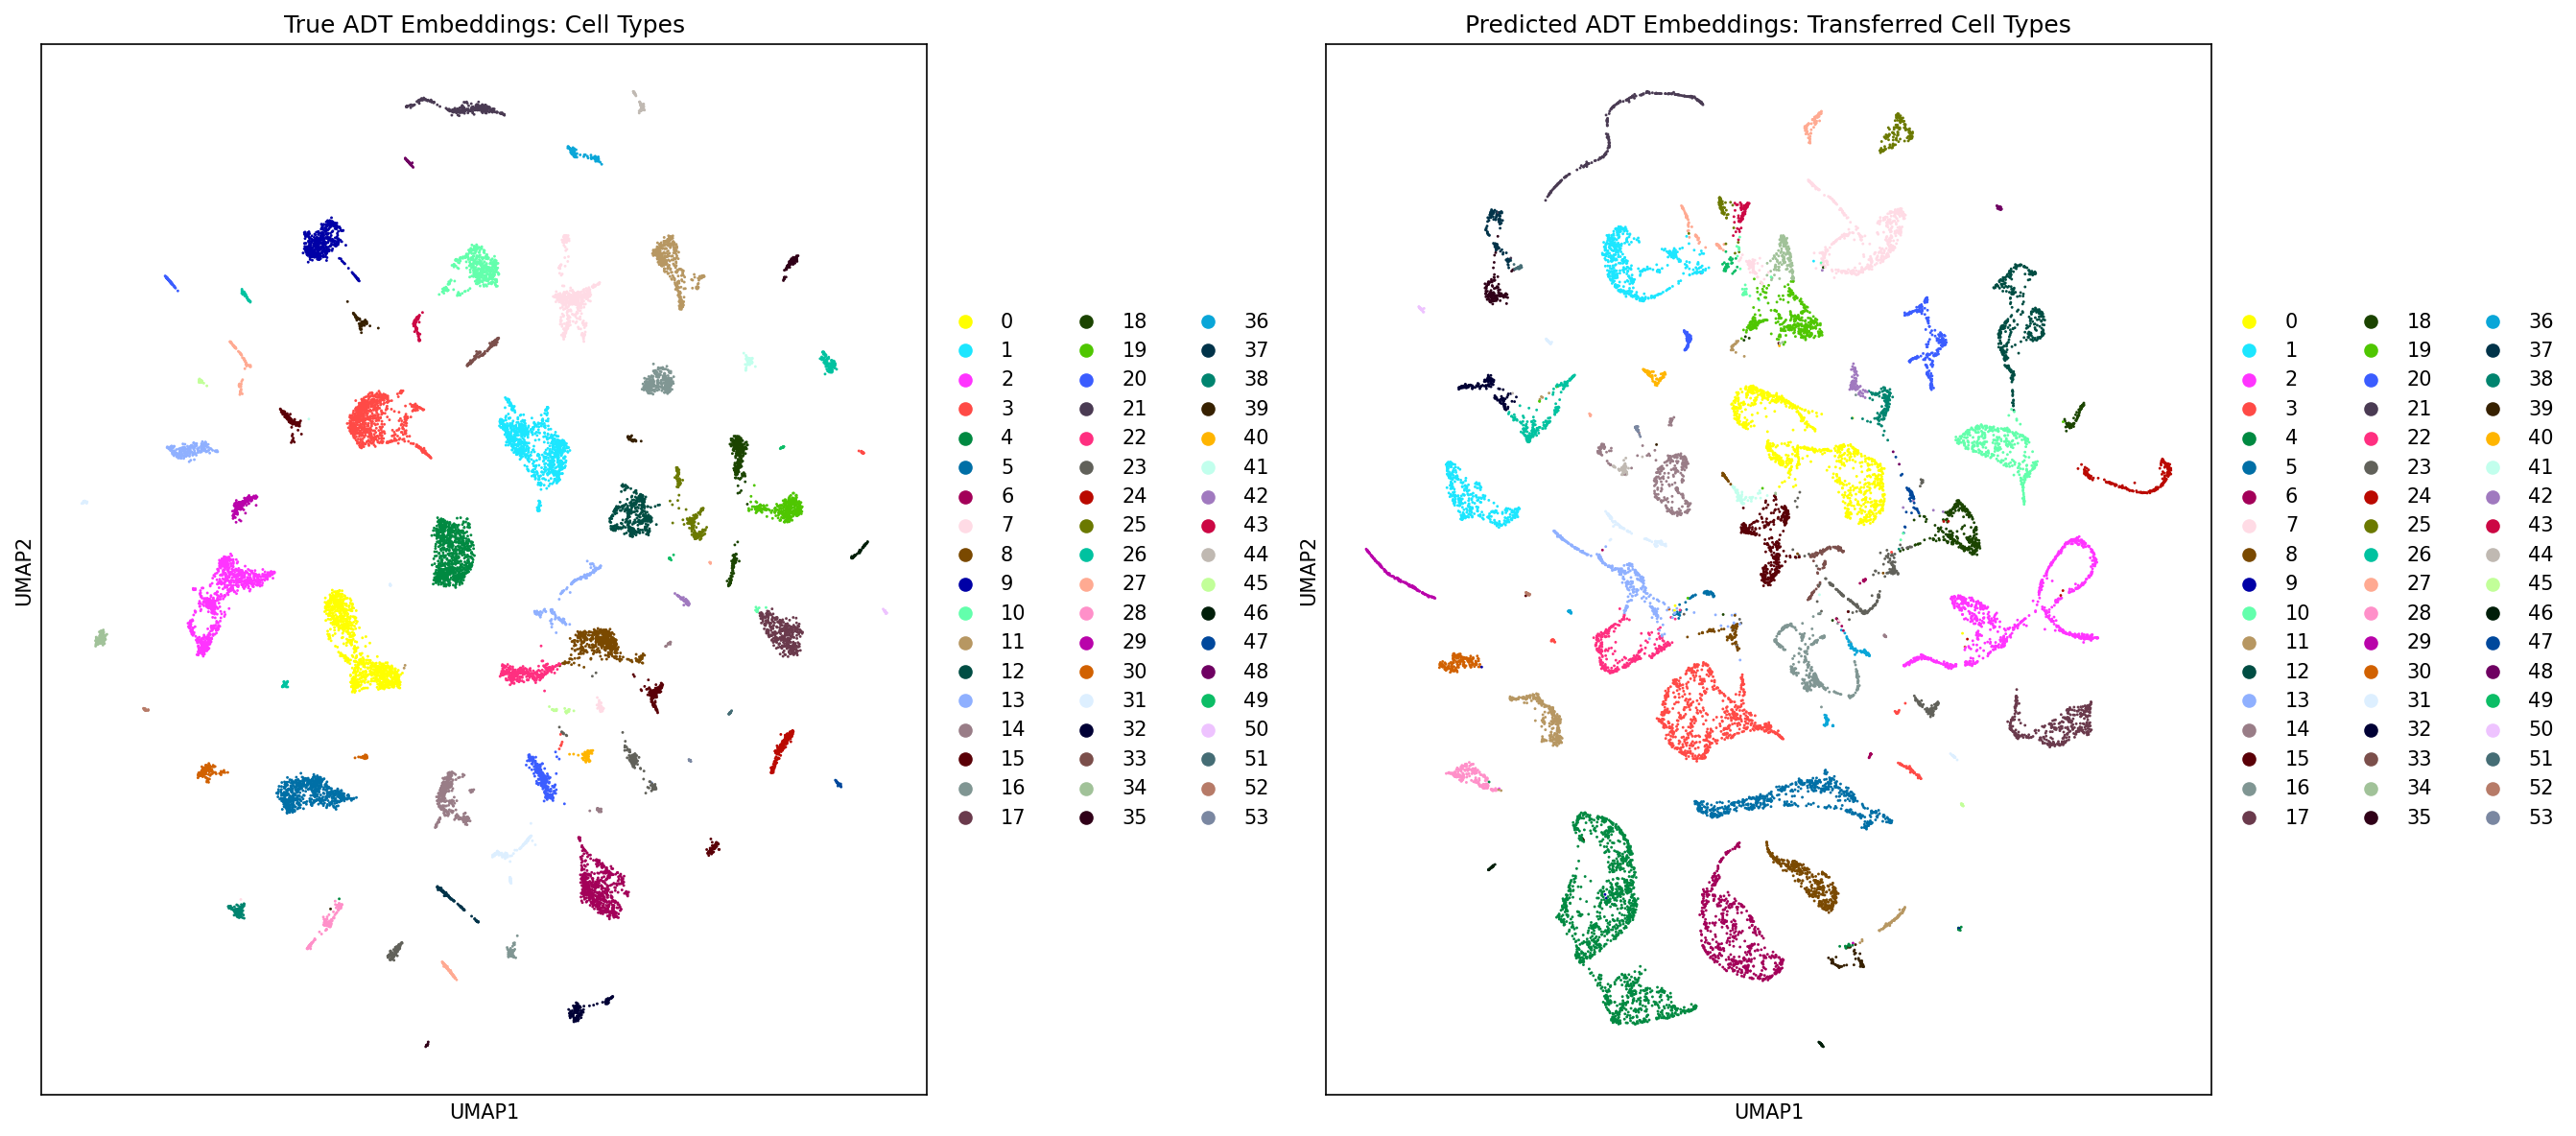

<Figure size 2100x1500 with 0 Axes>

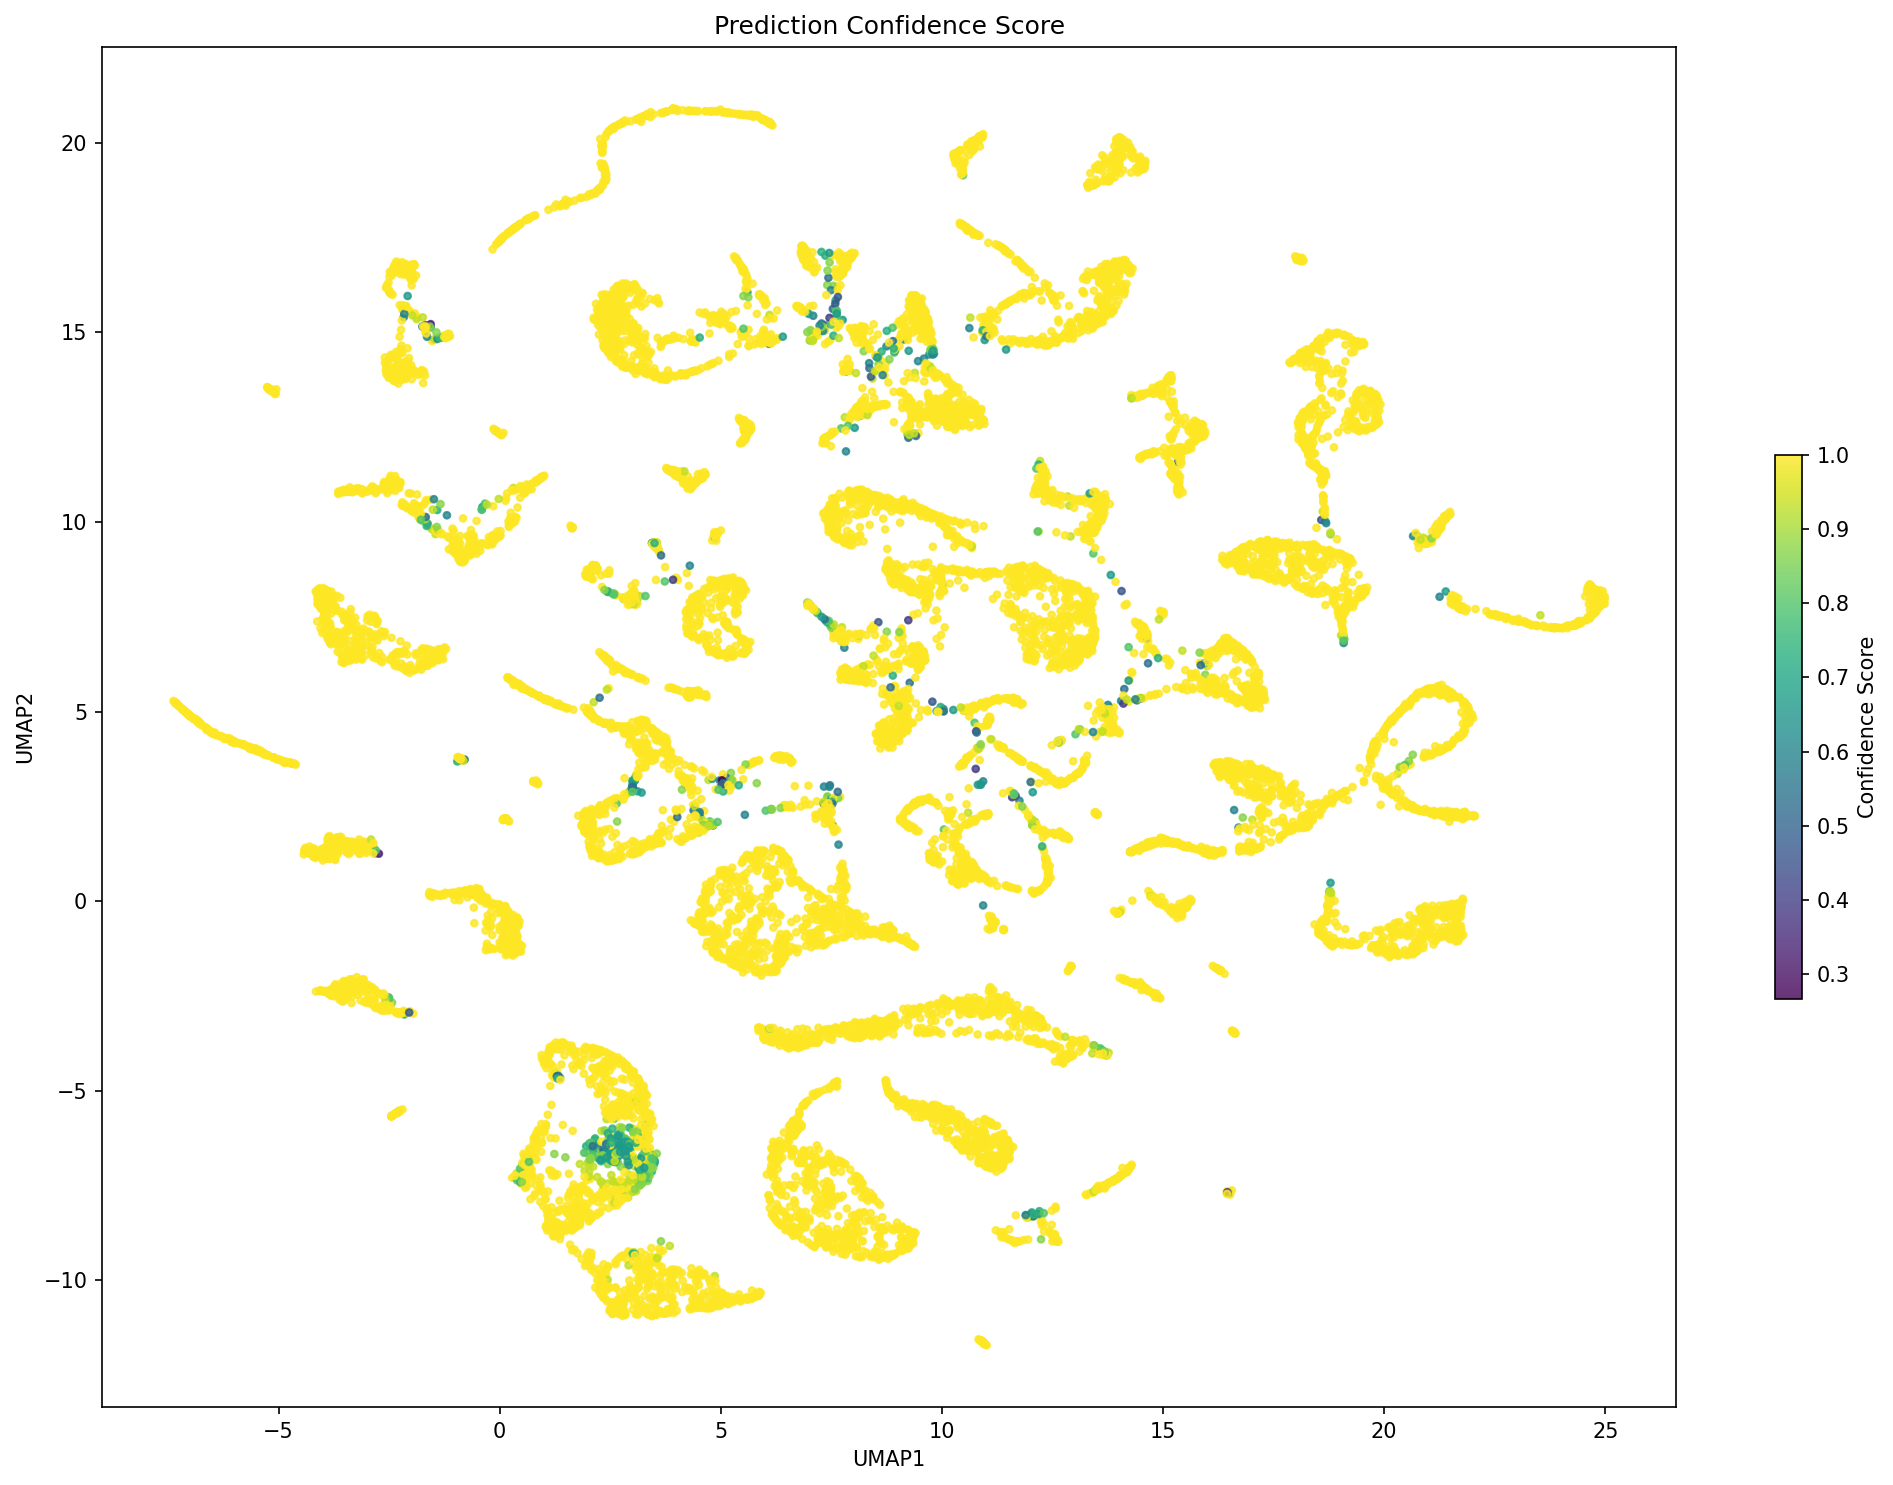

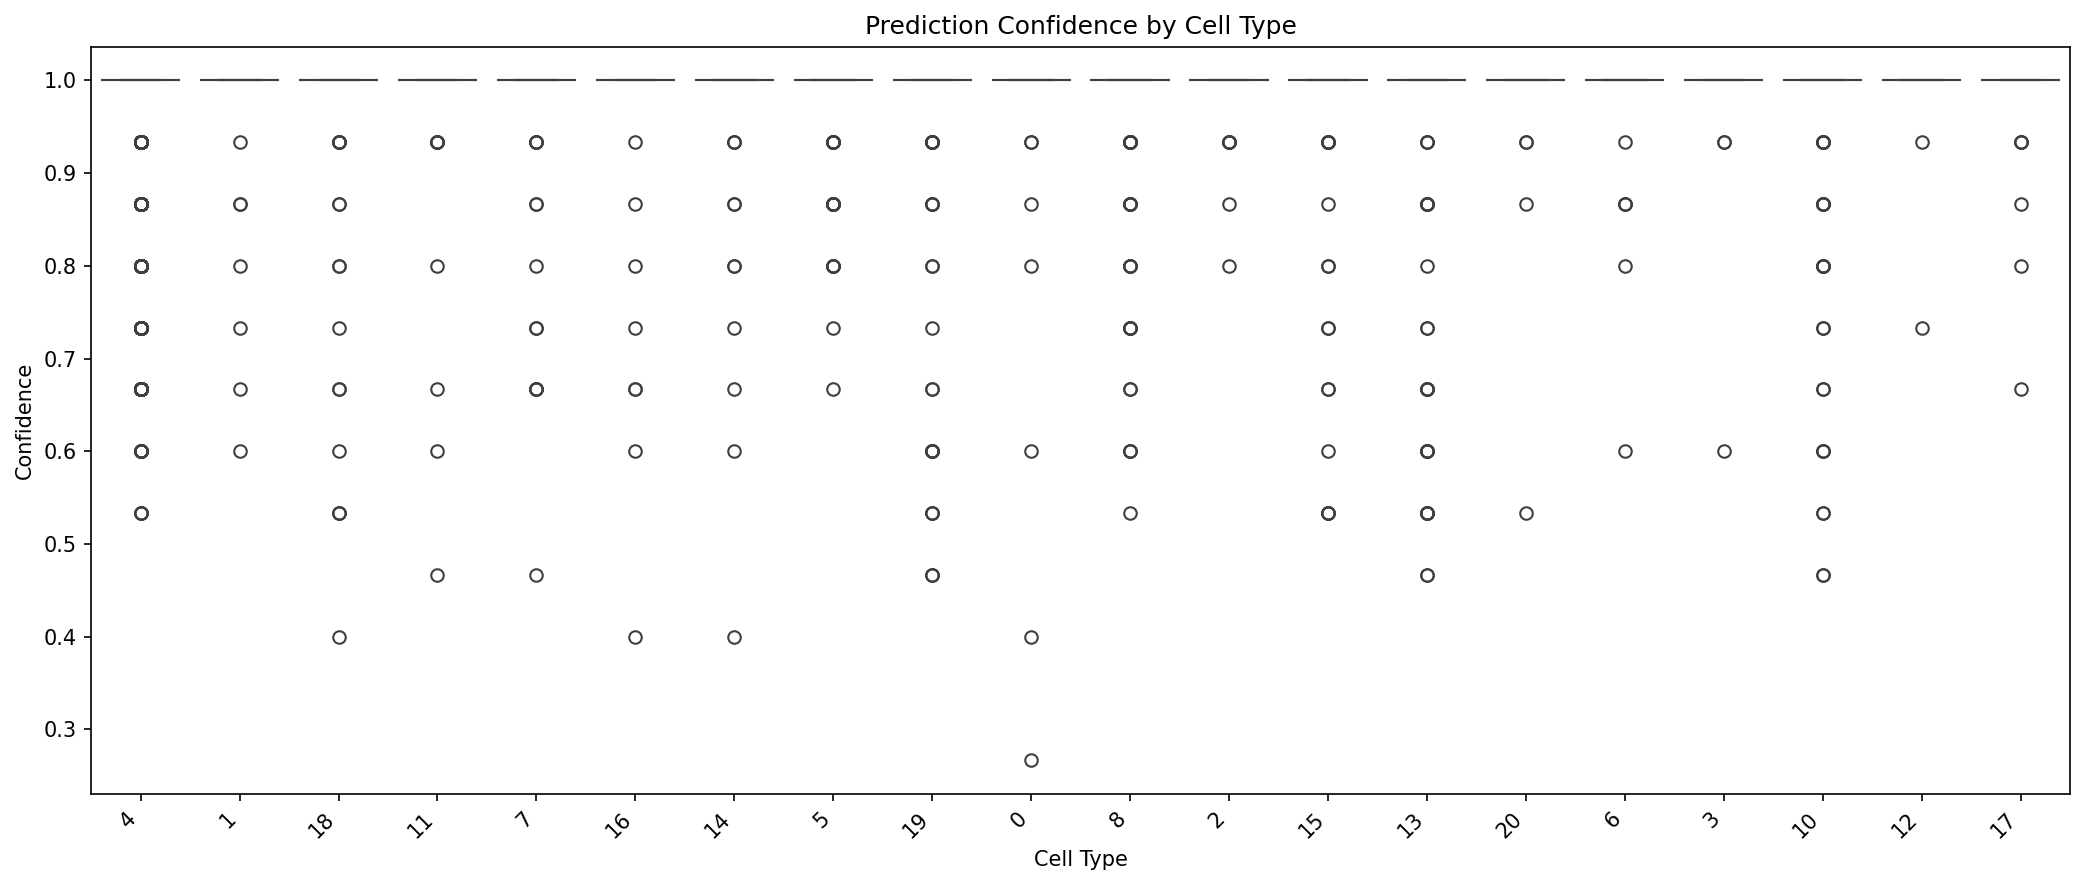


=== Cell Type Transfer Summary ===
Total cells: 15818
Unique cell types: 54
Overall accuracy: 0.8665

Top cell types by count and their metrics:


precision    recall  f1-score  support
macro avg      0.815111  0.801354  0.798725  15818.0
weighted avg   0.863081  0.866544  0.854958  15818.0
0              0.908000  0.915323  0.911647    992.0
1              0.956332  0.959474  0.957900    913.0
2              0.960046  0.956769  0.958405    879.0
3              0.969340  0.950289  0.959720    865.0
4              0.608759  0.975439  0.749663    855.0
5              0.927515  0.963134  0.944989    651.0
6              0.975490  0.977087  0.976288    611.0
7              0.907609  0.901079  0.904332    556.0


Results saved to 'predicted_cell_types.csv' and 'cell_type_transfer_metrics.csv'


In [25]:
# Cell Type Label Transfer for Predicted ADT Embeddings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import mode

print("Performing cell type label transfer from true ADT to predicted ADT embeddings...")

# First, check if we have cell type annotations for the ADT data
cell_type_column = None
available_annotations = []

# Look for potential cell type annotation columns
if hasattr(trainADT, 'obs'):
    available_annotations = [col for col in trainADT.obs.columns 
                           if col not in ['leiden', 'louvain', 'n_genes', 'n_counts', 'samples']]
    
    # Try to find a column that might contain cell type labels
    for col in ['cell_type', 'celltype', 'annotation', 'labels']:
        if col in available_annotations:
            cell_type_column = col
            break

# If no specific cell type annotation is found, we can use leiden clusters as proxy
if cell_type_column is None:
    print("No explicit cell type annotation found. Using leiden clusters as proxy for cell types.")
    cell_type_column = f'leiden_res{best_res}'
    
    # Ensure the column exists
    if cell_type_column not in true_adt_adata.obs:
        sc.tl.leiden(true_adt_adata, resolution=best_res, key_added=cell_type_column)
else:
    print(f"Using '{cell_type_column}' as cell type annotation.")
    
    # Copy annotation from trainADT to true_adt_adata (if they correspond)
    # This assumes the test_mask_np corresponds to the same indices in trainADT
    if hasattr(trainADT, 'obs') and cell_type_column in trainADT.obs:
        all_indices = np.arange(len(trainADT))
        test_indices = all_indices[test_mask_np]
        true_adt_adata.obs[cell_type_column] = trainADT.obs[cell_type_column].values[test_indices]

# Extract cell type labels
if cell_type_column in true_adt_adata.obs:
    cell_labels = true_adt_adata.obs[cell_type_column].values
    print(f"Found {len(np.unique(cell_labels))} unique cell types/clusters.")
else:
    # If we still don't have labels, create them from leiden clustering
    print("Creating cell type labels from leiden clustering.")
    sc.tl.leiden(true_adt_adata, resolution=1.0, key_added='leiden')
    cell_labels = true_adt_adata.obs['leiden'].values

# 1. kNN Label Transfer - train classifier on true ADT embeddings
n_neighbors = 15  # Number of neighbors to consider
knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
knn.fit(ground_truth, cell_labels)

# Apply classifier to predicted ADT embeddings
predicted_labels = knn.predict(predictions)
pred_adt_adata.obs['predicted_celltype'] = predicted_labels

# Calculate confidence scores (percentage of agreeing neighbors)
neighbor_indices = knn.kneighbors(predictions, return_distance=False)
confidence_scores = np.zeros(len(predictions))

for i, neighbors in enumerate(neighbor_indices):
    neighbor_labels = cell_labels[neighbors]
    # Convert to integers for bincount, handle strings if needed
    if neighbor_labels.dtype.kind == 'U' or neighbor_labels.dtype.kind == 'O':
        # Get unique labels and create a mapping
        unique_labels = np.unique(neighbor_labels)
        label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        int_labels = np.array([label_to_int[label] for label in neighbor_labels])
        most_common_count = np.bincount(int_labels).max()
    else:
        # For numeric labels, directly use bincount
        most_common_count = np.bincount(neighbor_labels.astype(int)).max()
        
    confidence_scores[i] = most_common_count / n_neighbors

pred_adt_adata.obs['prediction_confidence'] = confidence_scores

# Calculate transfer accuracy
accuracy = accuracy_score(cell_labels, predicted_labels)
print(f"Label transfer accuracy: {accuracy:.4f}")

# Create confusion matrix
conf_mat = confusion_matrix(cell_labels, predicted_labels)

# Normalize confusion matrix by row (true labels)
row_sums = conf_mat.sum(axis=1, keepdims=True)
conf_mat_norm = conf_mat / np.maximum(row_sums, 1)  # Avoid division by zero

# Plot confusion matrix
plt.figure(figsize=(12, 10))
unique_labels = np.unique(np.concatenate([cell_labels, predicted_labels]))
n_labels = len(unique_labels)

# If too many labels, limit the size
if n_labels > 30:
    print(f"Found {n_labels} unique labels, showing confusion matrix for top 30 most populous classes.")
    # Get counts for each class
    label_counts = np.bincount(cell_labels.astype(int)) if cell_labels.dtype.kind in 'ui' else pd.Series(cell_labels).value_counts().values
    
    # Get top 30 classes by count
    if cell_labels.dtype.kind in 'ui':
        top_labels_idx = np.argsort(label_counts)[-30:]
        show_labels = np.isin(cell_labels, top_labels_idx) & np.isin(predicted_labels, top_labels_idx)
    else:
        # For non-numeric labels
        top_labels = pd.Series(cell_labels).value_counts().nlargest(30).index
        show_labels = np.isin(cell_labels, top_labels) & np.isin(predicted_labels, top_labels)
    
    # Subset the data
    cell_labels_subset = cell_labels[show_labels]
    predicted_labels_subset = predicted_labels[show_labels]
    
    # Recompute confusion matrix
    conf_mat = confusion_matrix(cell_labels_subset, predicted_labels_subset)
    row_sums = conf_mat.sum(axis=1, keepdims=True)
    conf_mat_norm = conf_mat / np.maximum(row_sums, 1)
    
    unique_labels = np.unique(np.concatenate([cell_labels_subset, predicted_labels_subset]))
    n_labels = len(unique_labels)
    
# Create heatmap
sns.heatmap(conf_mat_norm, annot=(n_labels <= 20), fmt='.2f', 
            xticklabels=unique_labels if n_labels <= 40 else False,
            yticklabels=unique_labels if n_labels <= 40 else False,
            cmap='viridis')
plt.xlabel('Predicted Cell Type')
plt.ylabel('True Cell Type')
plt.title('Cell Type Label Transfer Confusion Matrix')
plt.tight_layout()
plt.savefig('cell_type_transfer_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Visualize UMAP with transferred labels
# Create a figure for UMAP visualization with transferred labels
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot true cell types on true ADT UMAP
if hasattr(true_adt_adata.obs, cell_type_column):
    sc.pl.umap(true_adt_adata, color=cell_type_column, title=f'True ADT Embeddings: Cell Types', 
               show=False, ax=axes[0], legend_loc='right margin' if n_labels > 20 else 'on data')
else:
    sc.pl.umap(true_adt_adata, color='leiden', title=f'True ADT Embeddings: Clusters', 
               show=False, ax=axes[0], legend_loc='right margin' if n_labels > 20 else 'on data')

# Plot predicted cell types on predicted ADT UMAP
sc.pl.umap(pred_adt_adata, color='predicted_celltype', title=f'Predicted ADT Embeddings: Transferred Cell Types', 
           show=False, ax=axes[1], legend_loc='right margin' if n_labels > 20 else 'on data')

plt.tight_layout()
plt.savefig('cell_type_transfer_umap.png', dpi=300, bbox_inches='tight')
plt.show()


# 3. Visualize prediction confidence
plt.figure(figsize=(14, 10))

# Color predicted UMAP by confidence score and capture the return value
# Alternative direct matplotlib approach
fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(
    pred_adt_adata.obsm['X_umap'][:, 0],
    pred_adt_adata.obsm['X_umap'][:, 1],
    c=pred_adt_adata.obs['prediction_confidence'],
    cmap='viridis', 
    s=10, 
    alpha=0.8
)
plt.colorbar(scatter, shrink=0.4, label='Confidence Score')
ax.set_title('Prediction Confidence Score')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
plt.tight_layout()
plt.savefig('cell_type_transfer_confidence.png', dpi=300, bbox_inches='tight')
plt.show()
# 4. Analyze confidence by cell type
confidence_by_celltype = pd.DataFrame({
    'Cell Type': predicted_labels,
    'Confidence': confidence_scores
})

# Get top 20 most common cell types
if len(np.unique(predicted_labels)) > 20:
    top_types = pd.Series(predicted_labels).value_counts().nlargest(20).index
    confidence_subset = confidence_by_celltype[confidence_by_celltype['Cell Type'].isin(top_types)]
else:
    confidence_subset = confidence_by_celltype

# Plot confidence by cell type
plt.figure(figsize=(14, 6))
sns.boxplot(x='Cell Type', y='Confidence', data=confidence_subset)
plt.xticks(rotation=45, ha='right')
plt.title('Prediction Confidence by Cell Type')
plt.tight_layout()
plt.savefig('cell_type_transfer_confidence_by_type.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a comprehensive summary of label transfer results
print("\n=== Cell Type Transfer Summary ===")
print(f"Total cells: {len(predicted_labels)}")
print(f"Unique cell types: {len(np.unique(cell_labels))}")
print(f"Overall accuracy: {accuracy:.4f}")

# Calculate accuracy for each cell type
# Convert labels to string to handle various label types
report = classification_report(cell_labels.astype(str), predicted_labels.astype(str), output_dict=True)
per_class_df = pd.DataFrame(report).T
per_class_df = per_class_df.sort_values('support', ascending=False)

# Display top classes by support
print("\nTop cell types by count and their metrics:")
display(per_class_df.head(10))

# Save the results
pred_adt_adata.obs.to_csv('predicted_cell_types.csv')
per_class_df.to_csv('cell_type_transfer_metrics.csv')
print("\nResults saved to 'predicted_cell_types.csv' and 'cell_type_transfer_metrics.csv'")

In [4]:
import scanpy as sc
UnseenData = sc.read_h5ad("/projects/vanaja_lab/satya/Datasets/GSE120221/GSE120221.h5ad")
UnseenData

AnnData object with n_obs × n_vars = 90653 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'unintegrated_clusters', 'seurat_clusters', 'RNA_snn_res.1'
    var: 'vf_vst_counts.GSM3396161_mean', 'vf_vst_counts.GSM3396161_variance', 'vf_vst_counts.GSM3396161_variance.expected', 'vf_vst_counts.GSM3396161_variance.standardized', 'vf_vst_counts.GSM3396161_variable', 'vf_vst_counts.GSM3396161_rank', 'vf_vst_counts.GSM3396162_mean', 'vf_vst_counts.GSM3396162_variance', 'vf_vst_counts.GSM3396162_variance.expected', 'vf_vst_counts.GSM3396162_variance.standardized', 'vf_vst_counts.GSM3396162_variable', 'vf_vst_counts.GSM3396162_rank', 'vf_vst_counts.GSM3396163_mean', 'vf_vst_counts.GSM3396163_variance', 'vf_vst_counts.GSM3396163_variance.expected', 'vf_vst_counts.GSM3396163_variance.standardized', 'vf_vst_counts.GSM3396163_variable', 'vf_vst_counts.GSM3396163_rank', 'vf_vst_counts.GSM3396164_mean', 'vf_vst_counts.GSM3396164_variance', 'vf_vst_counts.GSM3396164_variance.expec

## UMAP Visualization of Top Expressing Surface Marker Proteins

This section visualizes the predicted ADT embeddings colored by the expression levels of the most highly expressed surface marker proteins. This helps us understand how well the transformer model preserves the biological signal of key cell surface markers in the predicted embeddings.


## Summary

This notebook has successfully implemented a comprehensive pipeline for mapping between GAT embeddings of RNA and ADT data using a Transformer architecture. The key achievements include:

### Key Results:
1. **Transformer Mapping**: Successfully trained a transformer encoder to map RNA embeddings to ADT embeddings
2. **High-Quality Predictions**: Achieved strong correlation metrics between predicted and true ADT embeddings
3. **Cell Type Preservation**: Demonstrated that the model preserves cell type information through label transfer
4. **Surface Marker Visualization**: Created UMAP visualizations showing how top expressing surface marker proteins are distributed in the predicted embedding space

### Biological Insights:
- The UMAP visualization of top expressing surface marker proteins reveals how well the transformer model preserves the biological signal of key cell surface markers
- The expression patterns in the predicted embeddings should correlate with known cell type markers, providing validation of the model's biological relevance
- The top expressing proteins identified can serve as important biomarkers for cell type identification

### Technical Features:
- Memory-optimized training with gradient accumulation
- Comprehensive evaluation metrics (MSE, R², Pearson/Spearman correlations)
- Cell type label transfer with confidence scoring
- High-quality visualizations saved as publication-ready figures
- Detailed performance metrics and statistical summaries

The trained models can now be used to predict ADT embeddings from RNA data, enabling cross-modal analysis and integration for single-cell multi-omics studies.
